In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
from utils import read_dataset, plot_confusion_matrix
from models import RNNModel, ComplexRNNModel
from constants import BASIC_TRAINING_COLS, FORCE_CLASS_COLS, MASS_CLASS_COLS

# Preprocess dataset and prepare dataset loaders

In [21]:
def prepare_dataset(dataset, class_columns, normalise=False):

    X = []
    Y = []

    for trial in all_trials:
        X.append(np.array(trial[BASIC_TRAINING_COLS]).astype(np.float32))
        Y.append(np.argmax(np.array(trial[class_columns].iloc[0])))

    X = np.array(X)
    Y = np.array(Y)
    
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
    
    if normalise:
        attr_means = X_train.reshape(-1, X_train.shape[-1]).mean(axis=0)
        attr_std = X_train.reshape(-1, X_train.shape[-1]).std(axis=0)
        X_train = (X_train - attr_means) / attr_std
        X_val = (X_val - attr_means) / attr_std
        
    X_train = torch.from_numpy(X_train_scaled).cuda()
    X_val = torch.from_numpy(X_val_scaled).cuda()
    Y_train = torch.from_numpy(Y_train).type(torch.LongTensor).cuda()
    Y_val = torch.from_numpy(Y_val).type(torch.LongTensor).cuda()
    
    train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    return train_loader, val_loader

In [39]:
def training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=200):
    """Trains a model for <num_epochs> to minimize the <error> using the <optimizer>.
    Returns a list of epoch losses (averaged over batches) as well as validation accuracy"""
    
    epoch_losses = []
    epoch_accuracies = []
    
    for epoch in  tqdm(range(num_epochs)):

        epoch_loss = 0

        for x, y in train_loader:

            x = Variable(x)
            y = Variable(y)
            # Clear gradients
            optimizer.zero_grad()
            # Forward propagation
            y_hat = model(x)
            # Calculate softmax and cross entropy loss
            loss = error(y_hat, y)
            # Calculating gradients
            loss.backward()
            # Update parameters
            optimizer.step()

            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / len(train_loader))

        accuracy = evaluate(model, val_loader)

        epoch_accuracies.append(accuracy)

        print(epoch_losses[-1], epoch_accuracies[-1])
    
    return epoch_losses, epoch_accuracies

In [38]:
def evaluate(model, val_loader, return_predicted=False):
    predicted = []
    correct = 0
    total = 0
    for x_val, y_val in val_loader:
        x_val = Variable(x_val)
        y_hat = model(x_val)

        current_prediction = torch.max(y_hat.data, 1)[1]
        total += y_val.size(0)
        correct += (current_prediction == y_val).sum()
        
        predicted.extend(current_prediction)

        
    accuracy = 100 * correct / float(total)
    if return_predicted:
        return accuracy, predicted
    return accuracy

# MASS TRAINING 

## Read dataset and preprocess it

In [120]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader = prepare_dataset(all_trials, MASS_CLASS_COLS, normalise=True)

## Define model, loss and optimizer

In [121]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = X_train.shape[-1]    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [ ]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=600)

  0%|          | 1/600 [00:00<04:39,  2.14it/s]

1.099935531616211 tensor(38, device='cuda:0')


  0%|          | 2/600 [00:00<04:40,  2.13it/s]

1.0994775295257568 tensor(38, device='cuda:0')


  0%|          | 3/600 [00:01<04:32,  2.19it/s]

1.0990278720855713 tensor(40, device='cuda:0')


  1%|          | 4/600 [00:01<04:25,  2.25it/s]

1.098585844039917 tensor(38, device='cuda:0')


  1%|          | 5/600 [00:02<04:22,  2.26it/s]

1.0981500148773193 tensor(38, device='cuda:0')


  1%|          | 6/600 [00:02<04:20,  2.28it/s]

1.0977200269699097 tensor(37, device='cuda:0')


  1%|          | 7/600 [00:03<04:15,  2.32it/s]

1.0972951650619507 tensor(38, device='cuda:0')


  1%|▏         | 8/600 [00:03<04:12,  2.35it/s]

1.0968749523162842 tensor(39, device='cuda:0')


  2%|▏         | 9/600 [00:03<04:08,  2.38it/s]

1.0964586734771729 tensor(39, device='cuda:0')


  2%|▏         | 10/600 [00:04<04:07,  2.38it/s]

1.0960460901260376 tensor(40, device='cuda:0')


  2%|▏         | 11/600 [00:04<04:08,  2.37it/s]

1.0956363677978516 tensor(41, device='cuda:0')


  2%|▏         | 12/600 [00:05<04:11,  2.34it/s]

1.095228910446167 tensor(41, device='cuda:0')


  2%|▏         | 13/600 [00:05<04:11,  2.34it/s]

1.094822645187378 tensor(41, device='cuda:0')


  2%|▏         | 14/600 [00:06<04:11,  2.33it/s]

1.094416856765747 tensor(41, device='cuda:0')


  2%|▎         | 15/600 [00:06<04:12,  2.32it/s]

1.094010829925537 tensor(40, device='cuda:0')


  3%|▎         | 16/600 [00:06<04:09,  2.34it/s]

1.0936037302017212 tensor(40, device='cuda:0')


  3%|▎         | 17/600 [00:07<04:06,  2.37it/s]

1.0931938886642456 tensor(39, device='cuda:0')


  3%|▎         | 18/600 [00:07<04:07,  2.35it/s]

1.0927808284759521 tensor(38, device='cuda:0')


  3%|▎         | 19/600 [00:08<04:08,  2.34it/s]

1.0923634767532349 tensor(38, device='cuda:0')


  3%|▎         | 20/600 [00:08<04:06,  2.35it/s]

1.091940999031067 tensor(40, device='cuda:0')


  4%|▎         | 21/600 [00:08<04:01,  2.40it/s]

1.0915114879608154 tensor(40, device='cuda:0')


  4%|▎         | 22/600 [00:09<04:02,  2.39it/s]

1.0910747051239014 tensor(40, device='cuda:0')


  4%|▍         | 23/600 [00:09<04:05,  2.35it/s]

1.0906288623809814 tensor(40, device='cuda:0')


  4%|▍         | 24/600 [00:10<04:06,  2.34it/s]

1.0901738405227661 tensor(39, device='cuda:0')


  4%|▍         | 25/600 [00:10<04:06,  2.33it/s]

1.0897074937820435 tensor(38, device='cuda:0')


  4%|▍         | 26/600 [00:11<04:07,  2.32it/s]

1.0892295837402344 tensor(38, device='cuda:0')


  4%|▍         | 27/600 [00:11<04:07,  2.31it/s]

1.088738203048706 tensor(36, device='cuda:0')


  5%|▍         | 28/600 [00:12<04:08,  2.31it/s]

1.0882329940795898 tensor(36, device='cuda:0')


  5%|▍         | 29/600 [00:12<04:08,  2.30it/s]

1.0877121686935425 tensor(36, device='cuda:0')


  5%|▌         | 30/600 [00:12<04:07,  2.30it/s]

1.0871750116348267 tensor(35, device='cuda:0')


  5%|▌         | 31/600 [00:13<04:07,  2.30it/s]

1.0866206884384155 tensor(35, device='cuda:0')


  5%|▌         | 32/600 [00:13<04:05,  2.31it/s]

1.0860477685928345 tensor(35, device='cuda:0')


  6%|▌         | 33/600 [00:14<04:06,  2.30it/s]

1.0854547023773193 tensor(35, device='cuda:0')


  6%|▌         | 34/600 [00:14<04:06,  2.30it/s]

1.0848408937454224 tensor(35, device='cuda:0')


  6%|▌         | 35/600 [00:15<04:06,  2.29it/s]

1.0842050313949585 tensor(35, device='cuda:0')


  6%|▌         | 36/600 [00:15<04:05,  2.30it/s]

1.0835459232330322 tensor(36, device='cuda:0')


  6%|▌         | 37/600 [00:15<04:05,  2.30it/s]

1.082862377166748 tensor(36, device='cuda:0')


  6%|▋         | 38/600 [00:16<04:04,  2.30it/s]

1.082153081893921 tensor(35, device='cuda:0')


  6%|▋         | 39/600 [00:16<04:03,  2.30it/s]

1.0814167261123657 tensor(36, device='cuda:0')


  7%|▋         | 40/600 [00:17<04:03,  2.30it/s]

1.080652117729187 tensor(36, device='cuda:0')


  7%|▋         | 41/600 [00:17<04:02,  2.30it/s]

1.0798581838607788 tensor(36, device='cuda:0')


  7%|▋         | 42/600 [00:18<04:01,  2.31it/s]

1.0790332555770874 tensor(36, device='cuda:0')


  7%|▋         | 43/600 [00:18<04:02,  2.30it/s]

1.0781761407852173 tensor(36, device='cuda:0')


  7%|▋         | 44/600 [00:18<04:02,  2.30it/s]

1.0772852897644043 tensor(36, device='cuda:0')


  8%|▊         | 45/600 [00:19<04:01,  2.30it/s]

1.0763593912124634 tensor(36, device='cuda:0')


  8%|▊         | 46/600 [00:19<04:00,  2.30it/s]

1.0753965377807617 tensor(36, device='cuda:0')


  8%|▊         | 47/600 [00:20<04:00,  2.30it/s]

1.0743954181671143 tensor(37, device='cuda:0')


  8%|▊         | 48/600 [00:20<04:00,  2.29it/s]

1.0733537673950195 tensor(38, device='cuda:0')


  8%|▊         | 49/600 [00:21<04:00,  2.29it/s]

1.0722702741622925 tensor(38, device='cuda:0')


  8%|▊         | 50/600 [00:21<04:00,  2.29it/s]

1.0711420774459839 tensor(38, device='cuda:0')


  8%|▊         | 51/600 [00:22<03:59,  2.29it/s]

1.0699679851531982 tensor(38, device='cuda:0')


  9%|▊         | 52/600 [00:22<03:59,  2.29it/s]

1.0687453746795654 tensor(38, device='cuda:0')


  9%|▉         | 53/600 [00:22<03:55,  2.32it/s]

1.0674724578857422 tensor(39, device='cuda:0')


  9%|▉         | 54/600 [00:23<03:43,  2.44it/s]

1.066146969795227 tensor(39, device='cuda:0')


  9%|▉         | 55/600 [00:23<03:46,  2.41it/s]

1.0647673606872559 tensor(38, device='cuda:0')


  9%|▉         | 56/600 [00:24<03:45,  2.42it/s]

1.063331961631775 tensor(39, device='cuda:0')


 10%|▉         | 57/600 [00:24<03:47,  2.39it/s]

1.0618377923965454 tensor(39, device='cuda:0')


 10%|▉         | 58/600 [00:24<03:45,  2.41it/s]

1.0602819919586182 tensor(38, device='cuda:0')


 10%|▉         | 59/600 [00:25<03:45,  2.40it/s]

1.0586669445037842 tensor(38, device='cuda:0')


 10%|█         | 60/600 [00:25<03:43,  2.42it/s]

1.0570088624954224 tensor(38, device='cuda:0')


 10%|█         | 61/600 [00:26<03:44,  2.40it/s]

1.0553159713745117 tensor(37, device='cuda:0')


 10%|█         | 62/600 [00:26<03:41,  2.42it/s]

1.0535832643508911 tensor(36, device='cuda:0')


 10%|█         | 63/600 [00:26<03:40,  2.43it/s]

1.0518056154251099 tensor(37, device='cuda:0')


 11%|█         | 64/600 [00:27<03:39,  2.44it/s]

1.0499786138534546 tensor(37, device='cuda:0')


 11%|█         | 65/600 [00:27<03:39,  2.44it/s]

1.0480996370315552 tensor(37, device='cuda:0')


 11%|█         | 66/600 [00:28<03:37,  2.46it/s]

1.046165943145752 tensor(38, device='cuda:0')


 11%|█         | 67/600 [00:28<03:37,  2.45it/s]

1.0441745519638062 tensor(38, device='cuda:0')


 11%|█▏        | 68/600 [00:29<03:36,  2.45it/s]

1.042122483253479 tensor(38, device='cuda:0')


 12%|█▏        | 69/600 [00:29<03:38,  2.43it/s]

1.0400068759918213 tensor(39, device='cuda:0')


 12%|█▏        | 70/600 [00:29<03:38,  2.42it/s]

1.0378260612487793 tensor(39, device='cuda:0')


 12%|█▏        | 71/600 [00:30<03:42,  2.38it/s]

1.0355799198150635 tensor(40, device='cuda:0')


 12%|█▏        | 72/600 [00:30<03:43,  2.37it/s]

1.0332705974578857 tensor(40, device='cuda:0')


 12%|█▏        | 73/600 [00:31<03:41,  2.38it/s]

1.030902624130249 tensor(42, device='cuda:0')


 12%|█▏        | 74/600 [00:31<03:38,  2.41it/s]

1.0284819602966309 tensor(41, device='cuda:0')


 12%|█▎        | 75/600 [00:31<03:41,  2.37it/s]

1.026013970375061 tensor(41, device='cuda:0')


 13%|█▎        | 76/600 [00:32<03:39,  2.39it/s]

1.0235016345977783 tensor(41, device='cuda:0')


 13%|█▎        | 77/600 [00:32<03:38,  2.39it/s]

1.02094566822052 tensor(41, device='cuda:0')


 13%|█▎        | 78/600 [00:33<03:36,  2.41it/s]

1.018343448638916 tensor(42, device='cuda:0')


 13%|█▎        | 79/600 [00:33<03:35,  2.41it/s]

1.0156927108764648 tensor(42, device='cuda:0')


 13%|█▎        | 80/600 [00:34<03:34,  2.42it/s]

1.0129916667938232 tensor(43, device='cuda:0')


 14%|█▎        | 81/600 [00:34<03:31,  2.45it/s]

1.010239839553833 tensor(41, device='cuda:0')


 14%|█▎        | 82/600 [00:34<03:31,  2.45it/s]

1.0074374675750732 tensor(42, device='cuda:0')


 14%|█▍        | 83/600 [00:35<03:31,  2.44it/s]

1.0045857429504395 tensor(42, device='cuda:0')


 14%|█▍        | 84/600 [00:35<03:30,  2.45it/s]

1.001686453819275 tensor(42, device='cuda:0')


 14%|█▍        | 85/600 [00:36<03:30,  2.44it/s]

0.998742938041687 tensor(42, device='cuda:0')


 14%|█▍        | 86/600 [00:36<03:29,  2.46it/s]

0.9957598447799683 tensor(42, device='cuda:0')


 14%|█▍        | 87/600 [00:36<03:28,  2.46it/s]

0.9927427172660828 tensor(43, device='cuda:0')


 15%|█▍        | 88/600 [00:37<03:28,  2.46it/s]

0.9896928668022156 tensor(43, device='cuda:0')


 15%|█▍        | 89/600 [00:37<03:28,  2.45it/s]

0.986608624458313 tensor(43, device='cuda:0')


 15%|█▌        | 90/600 [00:38<03:28,  2.44it/s]

0.9834930300712585 tensor(43, device='cuda:0')


 15%|█▌        | 91/600 [00:38<03:28,  2.45it/s]

0.9803543090820312 tensor(43, device='cuda:0')


 15%|█▌        | 92/600 [00:38<03:27,  2.45it/s]

0.9771997332572937 tensor(42, device='cuda:0')


 16%|█▌        | 93/600 [00:39<03:27,  2.45it/s]

0.9740188717842102 tensor(42, device='cuda:0')


 16%|█▌        | 94/600 [00:39<03:26,  2.45it/s]

0.9707852602005005 tensor(41, device='cuda:0')


 16%|█▌        | 95/600 [00:40<03:26,  2.45it/s]

0.9674755930900574 tensor(41, device='cuda:0')


 16%|█▌        | 96/600 [00:40<03:23,  2.48it/s]

0.9640881419181824 tensor(41, device='cuda:0')


 16%|█▌        | 97/600 [00:40<03:24,  2.46it/s]

0.9606236219406128 tensor(41, device='cuda:0')


 16%|█▋        | 98/600 [00:41<03:22,  2.48it/s]

0.9570887684822083 tensor(41, device='cuda:0')


 16%|█▋        | 99/600 [00:41<03:22,  2.48it/s]

0.9534958600997925 tensor(42, device='cuda:0')


 17%|█▋        | 100/600 [00:42<03:22,  2.47it/s]

0.9498308897018433 tensor(44, device='cuda:0')


 17%|█▋        | 101/600 [00:42<03:22,  2.46it/s]

0.9461328387260437 tensor(44, device='cuda:0')


 17%|█▋        | 102/600 [00:42<03:22,  2.46it/s]

0.9424214363098145 tensor(44, device='cuda:0')


 17%|█▋        | 103/600 [00:43<03:31,  2.35it/s]

0.9386515617370605 tensor(44, device='cuda:0')


 17%|█▋        | 104/600 [00:43<03:27,  2.39it/s]

0.9348348379135132 tensor(44, device='cuda:0')


 18%|█▊        | 105/600 [00:44<03:26,  2.40it/s]

0.9310117959976196 tensor(45, device='cuda:0')


 18%|█▊        | 106/600 [00:44<03:24,  2.41it/s]

0.9271906614303589 tensor(45, device='cuda:0')


 18%|█▊        | 107/600 [00:45<03:22,  2.43it/s]

0.9232904314994812 tensor(46, device='cuda:0')


 18%|█▊        | 108/600 [00:45<03:21,  2.44it/s]

0.9194754362106323 tensor(47, device='cuda:0')


 18%|█▊        | 109/600 [00:45<03:20,  2.45it/s]

0.9156257510185242 tensor(46, device='cuda:0')


 18%|█▊        | 110/600 [00:46<03:19,  2.46it/s]

0.9117789268493652 tensor(45, device='cuda:0')


 18%|█▊        | 111/600 [00:46<03:19,  2.45it/s]

0.9078406095504761 tensor(45, device='cuda:0')


 19%|█▊        | 112/600 [00:47<03:17,  2.47it/s]

0.9039190411567688 tensor(45, device='cuda:0')


 19%|█▉        | 113/600 [00:47<03:16,  2.48it/s]

0.9004620313644409 tensor(45, device='cuda:0')


 19%|█▉        | 114/600 [00:47<03:16,  2.47it/s]

0.8968253135681152 tensor(45, device='cuda:0')


 19%|█▉        | 115/600 [00:48<03:16,  2.47it/s]

0.8928648233413696 tensor(45, device='cuda:0')


 19%|█▉        | 116/600 [00:48<03:19,  2.43it/s]

0.8887424468994141 tensor(45, device='cuda:0')


 20%|█▉        | 117/600 [00:49<03:18,  2.44it/s]

0.8845701217651367 tensor(46, device='cuda:0')


 20%|█▉        | 118/600 [00:49<03:08,  2.56it/s]

0.8803678750991821 tensor(46, device='cuda:0')


 20%|█▉        | 119/600 [00:49<03:10,  2.52it/s]

0.8759835958480835 tensor(45, device='cuda:0')


 20%|██        | 120/600 [00:50<03:12,  2.49it/s]

0.8719240427017212 tensor(45, device='cuda:0')


 20%|██        | 121/600 [00:50<03:11,  2.50it/s]

0.8676954507827759 tensor(44, device='cuda:0')


 20%|██        | 122/600 [00:51<03:12,  2.48it/s]

0.864151656627655 tensor(43, device='cuda:0')


 20%|██        | 123/600 [00:51<03:11,  2.49it/s]

0.8601380586624146 tensor(43, device='cuda:0')


 21%|██        | 124/600 [00:51<03:10,  2.50it/s]

0.8560513257980347 tensor(43, device='cuda:0')


 21%|██        | 125/600 [00:52<03:10,  2.50it/s]

0.8518955111503601 tensor(44, device='cuda:0')


 21%|██        | 126/600 [00:52<03:13,  2.45it/s]

0.8476618528366089 tensor(44, device='cuda:0')


 21%|██        | 127/600 [00:53<03:13,  2.44it/s]

0.8426302671432495 tensor(45, device='cuda:0')


 21%|██▏       | 128/600 [00:53<03:13,  2.44it/s]

0.8378850221633911 tensor(45, device='cuda:0')


 22%|██▏       | 129/600 [00:53<03:03,  2.57it/s]

0.833819568157196 tensor(44, device='cuda:0')


 22%|██▏       | 130/600 [00:54<03:05,  2.53it/s]

0.8303756713867188 tensor(43, device='cuda:0')


 22%|██▏       | 131/600 [00:54<03:09,  2.47it/s]

0.8262979388237 tensor(46, device='cuda:0')


 22%|██▏       | 132/600 [00:55<03:10,  2.45it/s]

0.8229961395263672 tensor(46, device='cuda:0')


 22%|██▏       | 133/600 [00:55<03:10,  2.45it/s]

0.8220316171646118 tensor(46, device='cuda:0')


 22%|██▏       | 134/600 [00:55<03:09,  2.46it/s]

0.815890908241272 tensor(47, device='cuda:0')


 22%|██▎       | 135/600 [00:56<03:09,  2.45it/s]

0.8122286796569824 tensor(47, device='cuda:0')


 23%|██▎       | 136/600 [00:56<03:09,  2.45it/s]

0.808449387550354 tensor(47, device='cuda:0')


 23%|██▎       | 137/600 [00:57<03:10,  2.44it/s]

0.8045681715011597 tensor(48, device='cuda:0')


 23%|██▎       | 138/600 [00:57<03:08,  2.45it/s]

0.8004837036132812 tensor(48, device='cuda:0')


 23%|██▎       | 139/600 [00:58<03:07,  2.46it/s]

0.7963045835494995 tensor(48, device='cuda:0')


 23%|██▎       | 140/600 [00:58<03:07,  2.46it/s]

0.7921156287193298 tensor(48, device='cuda:0')


 24%|██▎       | 141/600 [00:58<03:05,  2.47it/s]

0.7880162000656128 tensor(49, device='cuda:0')


 24%|██▎       | 142/600 [00:59<03:08,  2.43it/s]

0.7838771343231201 tensor(49, device='cuda:0')


 24%|██▍       | 143/600 [00:59<03:07,  2.44it/s]

0.7795382142066956 tensor(48, device='cuda:0')


 24%|██▍       | 144/600 [01:00<03:05,  2.46it/s]

0.7797633409500122 tensor(48, device='cuda:0')


 24%|██▍       | 145/600 [01:00<03:04,  2.46it/s]

0.7723104357719421 tensor(47, device='cuda:0')


 24%|██▍       | 146/600 [01:00<03:04,  2.47it/s]

0.7686143517494202 tensor(47, device='cuda:0')


 24%|██▍       | 147/600 [01:01<02:55,  2.58it/s]

0.7651019096374512 tensor(46, device='cuda:0')


 25%|██▍       | 148/600 [01:01<02:56,  2.55it/s]

0.7615026831626892 tensor(46, device='cuda:0')


 25%|██▍       | 149/600 [01:02<02:57,  2.54it/s]

0.7580909132957458 tensor(46, device='cuda:0')


 25%|██▌       | 150/600 [01:02<02:58,  2.53it/s]

0.7547803521156311 tensor(46, device='cuda:0')


 25%|██▌       | 151/600 [01:02<02:58,  2.52it/s]

0.7512890696525574 tensor(45, device='cuda:0')


 25%|██▌       | 152/600 [01:03<02:59,  2.50it/s]

0.7478941679000854 tensor(45, device='cuda:0')


 26%|██▌       | 153/600 [01:03<03:02,  2.45it/s]

0.7445124387741089 tensor(46, device='cuda:0')


 26%|██▌       | 154/600 [01:04<03:01,  2.46it/s]

0.7410891056060791 tensor(46, device='cuda:0')


 26%|██▌       | 155/600 [01:04<03:01,  2.45it/s]

0.7376483678817749 tensor(48, device='cuda:0')


 26%|██▌       | 156/600 [01:04<03:01,  2.45it/s]

0.7342239618301392 tensor(47, device='cuda:0')


 26%|██▌       | 157/600 [01:05<02:52,  2.57it/s]

0.730758547782898 tensor(48, device='cuda:0')


 26%|██▋       | 158/600 [01:05<02:53,  2.55it/s]

0.7272582054138184 tensor(48, device='cuda:0')


 26%|██▋       | 159/600 [01:06<02:54,  2.52it/s]

0.723720133304596 tensor(48, device='cuda:0')


 27%|██▋       | 160/600 [01:06<02:55,  2.51it/s]

0.7200482487678528 tensor(49, device='cuda:0')


 27%|██▋       | 161/600 [01:06<02:56,  2.49it/s]

0.7161663174629211 tensor(49, device='cuda:0')


 27%|██▋       | 162/600 [01:07<02:49,  2.59it/s]

0.712255597114563 tensor(49, device='cuda:0')


 27%|██▋       | 163/600 [01:07<02:51,  2.54it/s]

0.7086594700813293 tensor(49, device='cuda:0')


 27%|██▋       | 164/600 [01:07<02:52,  2.53it/s]

0.7057923674583435 tensor(50, device='cuda:0')


 28%|██▊       | 165/600 [01:08<02:52,  2.52it/s]

0.7093252539634705 tensor(50, device='cuda:0')


 28%|██▊       | 166/600 [01:08<02:53,  2.50it/s]

0.7063509225845337 tensor(50, device='cuda:0')


 28%|██▊       | 167/600 [01:09<02:54,  2.48it/s]

0.703179121017456 tensor(49, device='cuda:0')


 28%|██▊       | 168/600 [01:09<02:54,  2.48it/s]

0.7020978331565857 tensor(48, device='cuda:0')


 28%|██▊       | 169/600 [01:10<02:54,  2.47it/s]

0.6957014203071594 tensor(48, device='cuda:0')


 28%|██▊       | 170/600 [01:10<02:53,  2.48it/s]

0.6950103044509888 tensor(48, device='cuda:0')


 28%|██▊       | 171/600 [01:10<02:53,  2.48it/s]

0.6914138793945312 tensor(48, device='cuda:0')


 29%|██▊       | 172/600 [01:11<02:55,  2.44it/s]

0.6895086765289307 tensor(48, device='cuda:0')


 29%|██▉       | 173/600 [01:11<02:55,  2.43it/s]

0.6863152384757996 tensor(47, device='cuda:0')


 29%|██▉       | 174/600 [01:12<02:54,  2.44it/s]

0.6833493113517761 tensor(47, device='cuda:0')


 29%|██▉       | 175/600 [01:12<02:53,  2.45it/s]

0.681441068649292 tensor(47, device='cuda:0')


 29%|██▉       | 176/600 [01:12<02:52,  2.46it/s]

0.6785372495651245 tensor(47, device='cuda:0')


 30%|██▉       | 177/600 [01:13<02:44,  2.58it/s]

0.6758018136024475 tensor(48, device='cuda:0')


 30%|██▉       | 178/600 [01:13<02:44,  2.57it/s]

0.673419713973999 tensor(48, device='cuda:0')


 30%|██▉       | 179/600 [01:14<02:46,  2.53it/s]

0.6705083847045898 tensor(48, device='cuda:0')


 30%|███       | 180/600 [01:14<02:46,  2.53it/s]

0.6676633954048157 tensor(48, device='cuda:0')


 30%|███       | 181/600 [01:14<02:47,  2.50it/s]

0.6661465167999268 tensor(48, device='cuda:0')


 30%|███       | 182/600 [01:15<02:48,  2.48it/s]

0.6635941863059998 tensor(48, device='cuda:0')


 30%|███       | 183/600 [01:15<02:48,  2.48it/s]

0.6630679368972778 tensor(50, device='cuda:0')


 31%|███       | 184/600 [01:16<02:48,  2.47it/s]

0.6667941808700562 tensor(50, device='cuda:0')


 31%|███       | 185/600 [01:16<02:48,  2.47it/s]

0.6605930924415588 tensor(50, device='cuda:0')


 31%|███       | 186/600 [01:16<02:47,  2.48it/s]

0.6584794521331787 tensor(50, device='cuda:0')


 31%|███       | 187/600 [01:17<02:46,  2.48it/s]

0.6561113595962524 tensor(50, device='cuda:0')


 31%|███▏      | 188/600 [01:17<02:45,  2.49it/s]

0.6536365151405334 tensor(50, device='cuda:0')


 32%|███▏      | 189/600 [01:18<02:44,  2.50it/s]

0.6511868238449097 tensor(48, device='cuda:0')


 32%|███▏      | 190/600 [01:18<02:44,  2.48it/s]

0.6488319039344788 tensor(48, device='cuda:0')


 32%|███▏      | 191/600 [01:18<02:45,  2.47it/s]

0.6463369131088257 tensor(48, device='cuda:0')


 32%|███▏      | 192/600 [01:19<02:44,  2.48it/s]

0.6439076662063599 tensor(48, device='cuda:0')


 32%|███▏      | 193/600 [01:19<02:44,  2.47it/s]

0.6415133476257324 tensor(48, device='cuda:0')


 32%|███▏      | 194/600 [01:20<02:44,  2.47it/s]

0.6389466524124146 tensor(48, device='cuda:0')


 32%|███▎      | 195/600 [01:20<02:44,  2.46it/s]

0.6355615854263306 tensor(49, device='cuda:0')


 33%|███▎      | 196/600 [01:20<02:44,  2.46it/s]

0.6330295205116272 tensor(49, device='cuda:0')


 33%|███▎      | 197/600 [01:21<02:46,  2.43it/s]

0.6303949356079102 tensor(48, device='cuda:0')


 33%|███▎      | 198/600 [01:21<02:45,  2.43it/s]

0.6375091671943665 tensor(48, device='cuda:0')


 33%|███▎      | 199/600 [01:22<02:44,  2.44it/s]

0.6353481411933899 tensor(48, device='cuda:0')


 33%|███▎      | 200/600 [01:22<02:42,  2.46it/s]

0.6331796050071716 tensor(48, device='cuda:0')


 34%|███▎      | 201/600 [01:22<02:42,  2.46it/s]

0.6309852004051208 tensor(48, device='cuda:0')


 34%|███▎      | 202/600 [01:23<02:42,  2.45it/s]

0.6287853121757507 tensor(48, device='cuda:0')


 34%|███▍      | 203/600 [01:23<02:43,  2.43it/s]

0.6339386701583862 tensor(48, device='cuda:0')


 34%|███▍      | 204/600 [01:24<02:42,  2.43it/s]

0.6335340738296509 tensor(48, device='cuda:0')


 34%|███▍      | 205/600 [01:24<02:44,  2.40it/s]

0.6222765445709229 tensor(47, device='cuda:0')


 34%|███▍      | 206/600 [01:25<02:42,  2.42it/s]

0.6252353191375732 tensor(47, device='cuda:0')


 34%|███▍      | 207/600 [01:25<02:41,  2.44it/s]

0.6248472332954407 tensor(47, device='cuda:0')


 35%|███▍      | 208/600 [01:25<02:39,  2.45it/s]

0.6239176392555237 tensor(48, device='cuda:0')


 35%|███▍      | 209/600 [01:26<02:32,  2.56it/s]

0.6228554844856262 tensor(47, device='cuda:0')


 35%|███▌      | 210/600 [01:26<02:34,  2.52it/s]

0.6214250326156616 tensor(45, device='cuda:0')


 35%|███▌      | 211/600 [01:26<02:35,  2.50it/s]

0.6197691559791565 tensor(45, device='cuda:0')


 35%|███▌      | 212/600 [01:27<02:36,  2.48it/s]

0.6179143786430359 tensor(46, device='cuda:0')


 36%|███▌      | 213/600 [01:27<02:35,  2.48it/s]

0.6157151460647583 tensor(46, device='cuda:0')


 36%|███▌      | 214/600 [01:28<02:35,  2.48it/s]

0.6120483875274658 tensor(46, device='cuda:0')


 36%|███▌      | 215/600 [01:28<02:36,  2.46it/s]

0.6069291830062866 tensor(46, device='cuda:0')


 36%|███▌      | 216/600 [01:29<02:36,  2.45it/s]

0.6047000288963318 tensor(46, device='cuda:0')


 36%|███▌      | 217/600 [01:29<02:29,  2.56it/s]

0.602656364440918 tensor(46, device='cuda:0')


 36%|███▋      | 218/600 [01:29<02:31,  2.52it/s]

0.6007137894630432 tensor(47, device='cuda:0')


 36%|███▋      | 219/600 [01:30<02:34,  2.46it/s]

0.5988466739654541 tensor(48, device='cuda:0')


 37%|███▋      | 220/600 [01:30<02:34,  2.46it/s]

0.5966426730155945 tensor(48, device='cuda:0')


 37%|███▋      | 221/600 [01:31<02:34,  2.46it/s]

0.5938464999198914 tensor(50, device='cuda:0')


 37%|███▋      | 222/600 [01:31<02:35,  2.43it/s]

0.5914770364761353 tensor(51, device='cuda:0')


 37%|███▋      | 223/600 [01:31<02:34,  2.43it/s]

0.5891761779785156 tensor(50, device='cuda:0')


 37%|███▋      | 224/600 [01:32<02:34,  2.43it/s]

0.5922302603721619 tensor(50, device='cuda:0')


 38%|███▊      | 225/600 [01:32<02:35,  2.41it/s]

0.5962144136428833 tensor(50, device='cuda:0')


 38%|███▊      | 226/600 [01:33<02:34,  2.42it/s]

0.6006361842155457 tensor(50, device='cuda:0')


 38%|███▊      | 227/600 [01:33<02:33,  2.43it/s]

0.6010800004005432 tensor(50, device='cuda:0')


 38%|███▊      | 228/600 [01:33<02:26,  2.55it/s]

0.6010807752609253 tensor(50, device='cuda:0')


 38%|███▊      | 229/600 [01:34<02:20,  2.63it/s]

0.600314736366272 tensor(50, device='cuda:0')


 38%|███▊      | 230/600 [01:34<02:24,  2.56it/s]

0.5983299016952515 tensor(50, device='cuda:0')


 38%|███▊      | 231/600 [01:35<02:26,  2.52it/s]

0.5964844226837158 tensor(51, device='cuda:0')


 39%|███▊      | 232/600 [01:35<02:26,  2.51it/s]

0.5953363180160522 tensor(50, device='cuda:0')


 39%|███▉      | 233/600 [01:35<02:27,  2.49it/s]

0.5943594574928284 tensor(50, device='cuda:0')


 39%|███▉      | 234/600 [01:36<02:27,  2.48it/s]

0.5930018424987793 tensor(48, device='cuda:0')


 39%|███▉      | 235/600 [01:36<02:27,  2.47it/s]

0.5915077924728394 tensor(49, device='cuda:0')


 39%|███▉      | 236/600 [01:37<02:27,  2.46it/s]

0.5898889303207397 tensor(48, device='cuda:0')


 40%|███▉      | 237/600 [01:37<02:28,  2.45it/s]

0.5895830392837524 tensor(48, device='cuda:0')


 40%|███▉      | 238/600 [01:37<02:28,  2.44it/s]

0.5907537937164307 tensor(48, device='cuda:0')


 40%|███▉      | 239/600 [01:38<02:27,  2.44it/s]

0.5919832587242126 tensor(47, device='cuda:0')


 40%|████      | 240/600 [01:38<02:27,  2.44it/s]

0.5953502655029297 tensor(47, device='cuda:0')


 40%|████      | 241/600 [01:39<02:25,  2.46it/s]

0.5955185890197754 tensor(47, device='cuda:0')


 40%|████      | 242/600 [01:39<02:25,  2.46it/s]

0.5947089195251465 tensor(47, device='cuda:0')


 40%|████      | 243/600 [01:39<02:25,  2.45it/s]

0.5935385823249817 tensor(47, device='cuda:0')


 41%|████      | 244/600 [01:40<02:25,  2.45it/s]

0.592505931854248 tensor(48, device='cuda:0')


 41%|████      | 245/600 [01:40<02:24,  2.45it/s]

0.5914064645767212 tensor(48, device='cuda:0')


 41%|████      | 246/600 [01:41<02:25,  2.44it/s]

0.5902045369148254 tensor(48, device='cuda:0')


 41%|████      | 247/600 [01:41<02:25,  2.43it/s]

0.5886464715003967 tensor(48, device='cuda:0')


 41%|████▏     | 248/600 [01:41<02:20,  2.51it/s]

0.5868015289306641 tensor(48, device='cuda:0')


 42%|████▏     | 249/600 [01:42<02:19,  2.51it/s]

0.5851850509643555 tensor(48, device='cuda:0')


 42%|████▏     | 250/600 [01:42<02:20,  2.48it/s]

0.583622932434082 tensor(48, device='cuda:0')


 42%|████▏     | 251/600 [01:43<02:22,  2.45it/s]

0.5820914506912231 tensor(48, device='cuda:0')


 42%|████▏     | 252/600 [01:43<02:22,  2.44it/s]

0.5805937647819519 tensor(48, device='cuda:0')


 42%|████▏     | 253/600 [01:44<02:22,  2.43it/s]

0.5780795812606812 tensor(48, device='cuda:0')


 42%|████▏     | 254/600 [01:44<02:22,  2.42it/s]

0.5766827464103699 tensor(48, device='cuda:0')


 42%|████▎     | 255/600 [01:44<02:22,  2.42it/s]

0.5753402709960938 tensor(48, device='cuda:0')


 43%|████▎     | 256/600 [01:45<02:16,  2.53it/s]

0.5739830136299133 tensor(48, device='cuda:0')


 43%|████▎     | 257/600 [01:45<02:14,  2.55it/s]

0.5724178552627563 tensor(49, device='cuda:0')


 43%|████▎     | 258/600 [01:46<02:16,  2.51it/s]

0.570949912071228 tensor(50, device='cuda:0')


 43%|████▎     | 259/600 [01:46<02:16,  2.49it/s]

0.5699798464775085 tensor(50, device='cuda:0')


 43%|████▎     | 260/600 [01:46<02:17,  2.48it/s]

0.5679035782814026 tensor(50, device='cuda:0')


 44%|████▎     | 261/600 [01:47<02:11,  2.58it/s]

0.5662814378738403 tensor(50, device='cuda:0')


 44%|████▎     | 262/600 [01:47<02:13,  2.54it/s]

0.5652722716331482 tensor(50, device='cuda:0')


 44%|████▍     | 263/600 [01:47<02:14,  2.51it/s]

0.5639857053756714 tensor(50, device='cuda:0')


 44%|████▍     | 264/600 [01:48<02:15,  2.48it/s]

0.5626388788223267 tensor(50, device='cuda:0')


 44%|████▍     | 265/600 [01:48<02:14,  2.48it/s]

0.5612013339996338 tensor(49, device='cuda:0')


 44%|████▍     | 266/600 [01:49<02:09,  2.58it/s]

0.5596240758895874 tensor(49, device='cuda:0')


 44%|████▍     | 267/600 [01:49<02:11,  2.54it/s]

0.5579020977020264 tensor(49, device='cuda:0')


 45%|████▍     | 268/600 [01:49<02:12,  2.51it/s]

0.5560624599456787 tensor(48, device='cuda:0')


 45%|████▍     | 269/600 [01:50<02:13,  2.48it/s]

0.5543064475059509 tensor(48, device='cuda:0')


 45%|████▌     | 270/600 [01:50<02:12,  2.48it/s]

0.5527492761611938 tensor(48, device='cuda:0')


 45%|████▌     | 271/600 [01:51<02:12,  2.49it/s]

0.551324725151062 tensor(48, device='cuda:0')


 45%|████▌     | 272/600 [01:51<02:08,  2.55it/s]

0.549883246421814 tensor(48, device='cuda:0')


 46%|████▌     | 273/600 [01:51<02:09,  2.53it/s]

0.5485281348228455 tensor(49, device='cuda:0')


 46%|████▌     | 274/600 [01:52<02:10,  2.49it/s]

0.5474601984024048 tensor(50, device='cuda:0')


 46%|████▌     | 275/600 [01:52<02:11,  2.47it/s]

0.545975923538208 tensor(50, device='cuda:0')


 46%|████▌     | 276/600 [01:53<02:11,  2.47it/s]

0.5447554588317871 tensor(50, device='cuda:0')


 46%|████▌     | 277/600 [01:53<02:11,  2.46it/s]

0.5435471534729004 tensor(50, device='cuda:0')


 46%|████▋     | 278/600 [01:54<02:11,  2.46it/s]

0.5423401594161987 tensor(49, device='cuda:0')


 46%|████▋     | 279/600 [01:54<02:10,  2.46it/s]

0.5411275625228882 tensor(49, device='cuda:0')


 47%|████▋     | 280/600 [01:54<02:10,  2.45it/s]

0.5399061441421509 tensor(49, device='cuda:0')


 47%|████▋     | 281/600 [01:55<02:10,  2.45it/s]

0.5386947393417358 tensor(49, device='cuda:0')


 47%|████▋     | 282/600 [01:55<02:09,  2.45it/s]

0.537487268447876 tensor(49, device='cuda:0')


 47%|████▋     | 283/600 [01:56<02:08,  2.46it/s]

0.5362769961357117 tensor(49, device='cuda:0')


 47%|████▋     | 284/600 [01:56<02:08,  2.46it/s]

0.5350803136825562 tensor(49, device='cuda:0')


 48%|████▊     | 285/600 [01:56<02:08,  2.46it/s]

0.5338886976242065 tensor(48, device='cuda:0')


 48%|████▊     | 286/600 [01:57<02:08,  2.45it/s]

0.5326884984970093 tensor(48, device='cuda:0')


 48%|████▊     | 287/600 [01:57<02:08,  2.43it/s]

0.5314855575561523 tensor(48, device='cuda:0')


 48%|████▊     | 288/600 [01:58<02:07,  2.44it/s]

0.5273751020431519 tensor(48, device='cuda:0')


 48%|████▊     | 289/600 [01:58<02:07,  2.43it/s]

0.5262189507484436 tensor(48, device='cuda:0')


 48%|████▊     | 290/600 [01:58<02:06,  2.44it/s]

0.5250979661941528 tensor(48, device='cuda:0')


 48%|████▊     | 291/600 [01:59<02:06,  2.45it/s]

0.5240002870559692 tensor(48, device='cuda:0')


 49%|████▊     | 292/600 [01:59<02:05,  2.45it/s]

0.52291339635849 tensor(48, device='cuda:0')


 49%|████▉     | 293/600 [02:00<02:05,  2.45it/s]

0.5218285918235779 tensor(48, device='cuda:0')


 49%|████▉     | 294/600 [02:00<02:04,  2.45it/s]

0.5207422971725464 tensor(49, device='cuda:0')


 49%|████▉     | 295/600 [02:00<02:04,  2.44it/s]

0.5196573734283447 tensor(51, device='cuda:0')


 49%|████▉     | 296/600 [02:01<02:04,  2.44it/s]

0.5185707807540894 tensor(51, device='cuda:0')


 50%|████▉     | 297/600 [02:01<02:03,  2.45it/s]

0.5191176533699036 tensor(51, device='cuda:0')


 50%|████▉     | 298/600 [02:02<02:04,  2.43it/s]

0.5163730382919312 tensor(51, device='cuda:0')


 50%|████▉     | 299/600 [02:02<02:03,  2.43it/s]

0.5152547359466553 tensor(50, device='cuda:0')


 50%|█████     | 300/600 [02:03<02:02,  2.45it/s]

0.5140987634658813 tensor(50, device='cuda:0')


 50%|█████     | 301/600 [02:03<02:02,  2.45it/s]

0.5128740072250366 tensor(50, device='cuda:0')


 50%|█████     | 302/600 [02:03<02:01,  2.45it/s]

0.511548638343811 tensor(50, device='cuda:0')


 50%|█████     | 303/600 [02:04<02:01,  2.45it/s]

0.5101265907287598 tensor(50, device='cuda:0')


 51%|█████     | 304/600 [02:04<02:01,  2.44it/s]

0.508682906627655 tensor(50, device='cuda:0')


 51%|█████     | 305/600 [02:05<02:01,  2.44it/s]

0.5073422193527222 tensor(50, device='cuda:0')


 51%|█████     | 306/600 [02:05<02:00,  2.45it/s]

0.5061421394348145 tensor(50, device='cuda:0')


 51%|█████     | 307/600 [02:05<02:01,  2.41it/s]

0.5050381422042847 tensor(50, device='cuda:0')


 51%|█████▏    | 308/600 [02:06<01:57,  2.49it/s]

0.5038005113601685 tensor(50, device='cuda:0')


 52%|█████▏    | 309/600 [02:06<01:54,  2.55it/s]

0.5025919079780579 tensor(50, device='cuda:0')


 52%|█████▏    | 310/600 [02:07<01:57,  2.47it/s]

0.5013273358345032 tensor(50, device='cuda:0')


 52%|█████▏    | 311/600 [02:07<01:57,  2.46it/s]

0.5002557635307312 tensor(50, device='cuda:0')


 52%|█████▏    | 312/600 [02:07<01:57,  2.45it/s]

0.49910083413124084 tensor(50, device='cuda:0')


 52%|█████▏    | 313/600 [02:08<01:58,  2.41it/s]

0.49808818101882935 tensor(50, device='cuda:0')


 52%|█████▏    | 314/600 [02:08<01:57,  2.43it/s]

0.49685534834861755 tensor(50, device='cuda:0')


 52%|█████▎    | 315/600 [02:09<01:57,  2.42it/s]

0.495861679315567 tensor(50, device='cuda:0')


 53%|█████▎    | 316/600 [02:09<01:56,  2.43it/s]

0.49489063024520874 tensor(50, device='cuda:0')


 53%|█████▎    | 317/600 [02:09<01:56,  2.43it/s]

0.4939500689506531 tensor(50, device='cuda:0')


 53%|█████▎    | 318/600 [02:10<01:56,  2.43it/s]

0.49302634596824646 tensor(50, device='cuda:0')


 53%|█████▎    | 319/600 [02:10<01:54,  2.45it/s]

0.4921126365661621 tensor(50, device='cuda:0')


 53%|█████▎    | 320/600 [02:11<01:55,  2.43it/s]

0.4911990761756897 tensor(50, device='cuda:0')


 54%|█████▎    | 321/600 [02:11<01:54,  2.44it/s]

0.49028024077415466 tensor(49, device='cuda:0')


 54%|█████▎    | 322/600 [02:12<01:54,  2.44it/s]

0.4893593192100525 tensor(49, device='cuda:0')


 54%|█████▍    | 323/600 [02:12<01:49,  2.54it/s]

0.4884238839149475 tensor(49, device='cuda:0')


 54%|█████▍    | 324/600 [02:12<01:49,  2.51it/s]

0.48752444982528687 tensor(49, device='cuda:0')


 54%|█████▍    | 325/600 [02:13<01:51,  2.48it/s]

0.4864724576473236 tensor(49, device='cuda:0')


 54%|█████▍    | 326/600 [02:13<01:51,  2.46it/s]

0.48516178131103516 tensor(49, device='cuda:0')


 55%|█████▍    | 327/600 [02:14<01:51,  2.45it/s]

0.4832187592983246 tensor(49, device='cuda:0')


 55%|█████▍    | 328/600 [02:14<01:50,  2.46it/s]

0.481684148311615 tensor(49, device='cuda:0')


 55%|█████▍    | 329/600 [02:14<01:50,  2.44it/s]

0.4807930588722229 tensor(49, device='cuda:0')


 55%|█████▌    | 330/600 [02:15<01:50,  2.44it/s]

0.4799558222293854 tensor(49, device='cuda:0')


 55%|█████▌    | 331/600 [02:15<01:50,  2.44it/s]

0.47907453775405884 tensor(48, device='cuda:0')


 55%|█████▌    | 332/600 [02:16<01:50,  2.43it/s]

0.4782271981239319 tensor(48, device='cuda:0')


 56%|█████▌    | 333/600 [02:16<01:49,  2.43it/s]

0.47749677300453186 tensor(48, device='cuda:0')


 56%|█████▌    | 334/600 [02:16<01:44,  2.54it/s]

0.47658437490463257 tensor(48, device='cuda:0')


 56%|█████▌    | 335/600 [02:17<01:45,  2.52it/s]

0.47585368156433105 tensor(48, device='cuda:0')


 56%|█████▌    | 336/600 [02:17<01:45,  2.49it/s]

0.4750252664089203 tensor(48, device='cuda:0')


 56%|█████▌    | 337/600 [02:18<01:46,  2.47it/s]

0.4741676449775696 tensor(48, device='cuda:0')


 56%|█████▋    | 338/600 [02:18<01:46,  2.46it/s]

0.4732738137245178 tensor(48, device='cuda:0')


 56%|█████▋    | 339/600 [02:18<01:46,  2.46it/s]

0.47738614678382874 tensor(48, device='cuda:0')


 57%|█████▋    | 340/600 [02:19<01:45,  2.46it/s]

0.474059522151947 tensor(48, device='cuda:0')


 57%|█████▋    | 341/600 [02:19<01:46,  2.43it/s]

0.47131890058517456 tensor(49, device='cuda:0')


 57%|█████▋    | 342/600 [02:20<01:46,  2.43it/s]

0.4707128405570984 tensor(49, device='cuda:0')


 57%|█████▋    | 343/600 [02:20<01:45,  2.43it/s]

0.47010478377342224 tensor(48, device='cuda:0')


 57%|█████▋    | 344/600 [02:20<01:45,  2.44it/s]

0.4692915380001068 tensor(48, device='cuda:0')


 57%|█████▊    | 345/600 [02:21<01:44,  2.44it/s]

0.46868887543678284 tensor(48, device='cuda:0')


 58%|█████▊    | 346/600 [02:21<01:43,  2.45it/s]

0.4681466221809387 tensor(48, device='cuda:0')


 58%|█████▊    | 347/600 [02:22<01:43,  2.44it/s]

0.4674901068210602 tensor(48, device='cuda:0')


 58%|█████▊    | 348/600 [02:22<01:43,  2.44it/s]

0.466688334941864 tensor(48, device='cuda:0')


 58%|█████▊    | 349/600 [02:22<01:42,  2.44it/s]

0.4658060073852539 tensor(48, device='cuda:0')


 58%|█████▊    | 350/600 [02:23<01:42,  2.43it/s]

0.4649258255958557 tensor(49, device='cuda:0')


 58%|█████▊    | 351/600 [02:23<01:42,  2.43it/s]

0.46409425139427185 tensor(49, device='cuda:0')


 59%|█████▊    | 352/600 [02:24<01:41,  2.44it/s]

0.4633122980594635 tensor(49, device='cuda:0')


 59%|█████▉    | 353/600 [02:24<01:41,  2.43it/s]

0.4625275731086731 tensor(49, device='cuda:0')


 59%|█████▉    | 354/600 [02:25<01:40,  2.44it/s]

0.4616773724555969 tensor(49, device='cuda:0')


 59%|█████▉    | 355/600 [02:25<01:40,  2.43it/s]

0.4607767164707184 tensor(49, device='cuda:0')


 59%|█████▉    | 356/600 [02:25<01:40,  2.43it/s]

0.45983877778053284 tensor(49, device='cuda:0')


 60%|█████▉    | 357/600 [02:26<01:39,  2.43it/s]

0.4587384760379791 tensor(49, device='cuda:0')


 60%|█████▉    | 358/600 [02:26<01:40,  2.42it/s]

0.45742812752723694 tensor(49, device='cuda:0')


 60%|█████▉    | 359/600 [02:27<01:39,  2.43it/s]

0.45583200454711914 tensor(49, device='cuda:0')


 60%|██████    | 360/600 [02:27<01:38,  2.43it/s]

0.454904705286026 tensor(49, device='cuda:0')


 60%|██████    | 361/600 [02:27<01:37,  2.44it/s]

0.4542243480682373 tensor(50, device='cuda:0')


 60%|██████    | 362/600 [02:28<01:37,  2.44it/s]

0.4535638391971588 tensor(50, device='cuda:0')


 60%|██████    | 363/600 [02:28<01:36,  2.45it/s]

0.4528881907463074 tensor(50, device='cuda:0')


 61%|██████    | 364/600 [02:29<01:36,  2.44it/s]

0.4521387219429016 tensor(50, device='cuda:0')


 61%|██████    | 365/600 [02:29<01:37,  2.41it/s]

0.45137375593185425 tensor(50, device='cuda:0')


 61%|██████    | 366/600 [02:29<01:36,  2.42it/s]

0.4506220817565918 tensor(49, device='cuda:0')


 61%|██████    | 367/600 [02:30<01:35,  2.43it/s]

0.4498721957206726 tensor(49, device='cuda:0')


 61%|██████▏   | 368/600 [02:30<01:35,  2.44it/s]

0.44914060831069946 tensor(49, device='cuda:0')


 62%|██████▏   | 369/600 [02:31<01:31,  2.54it/s]

0.4484178423881531 tensor(49, device='cuda:0')


 62%|██████▏   | 370/600 [02:31<01:31,  2.51it/s]

0.4512966573238373 tensor(49, device='cuda:0')


 62%|██████▏   | 371/600 [02:31<01:32,  2.49it/s]

0.4506344795227051 tensor(49, device='cuda:0')


 62%|██████▏   | 372/600 [02:32<01:32,  2.47it/s]

0.4499337673187256 tensor(50, device='cuda:0')


 62%|██████▏   | 373/600 [02:32<01:31,  2.47it/s]

0.449580579996109 tensor(50, device='cuda:0')


 62%|██████▏   | 374/600 [02:33<01:32,  2.44it/s]

0.4486676752567291 tensor(50, device='cuda:0')


 62%|██████▎   | 375/600 [02:33<01:36,  2.34it/s]

0.45081838965415955 tensor(50, device='cuda:0')


 63%|██████▎   | 376/600 [02:34<01:34,  2.37it/s]

0.4501558244228363 tensor(50, device='cuda:0')


 63%|██████▎   | 377/600 [02:34<01:33,  2.38it/s]

0.44946885108947754 tensor(50, device='cuda:0')


 63%|██████▎   | 378/600 [02:34<01:28,  2.50it/s]

0.448687881231308 tensor(50, device='cuda:0')


 63%|██████▎   | 379/600 [02:35<01:25,  2.58it/s]

0.44540873169898987 tensor(49, device='cuda:0')


 63%|██████▎   | 380/600 [02:35<01:26,  2.53it/s]

0.4442974627017975 tensor(49, device='cuda:0')


 64%|██████▎   | 381/600 [02:36<01:27,  2.51it/s]

0.44369086623191833 tensor(49, device='cuda:0')


 64%|██████▎   | 382/600 [02:36<01:27,  2.48it/s]

0.4430913031101227 tensor(49, device='cuda:0')


 64%|██████▍   | 383/600 [02:36<01:27,  2.47it/s]

0.44249194860458374 tensor(49, device='cuda:0')


 64%|██████▍   | 384/600 [02:37<01:27,  2.46it/s]

0.4418800473213196 tensor(49, device='cuda:0')


 64%|██████▍   | 385/600 [02:37<01:28,  2.44it/s]

0.44124117493629456 tensor(49, device='cuda:0')


 64%|██████▍   | 386/600 [02:38<01:27,  2.44it/s]

0.4406108856201172 tensor(49, device='cuda:0')


 64%|██████▍   | 387/600 [02:38<01:27,  2.43it/s]

0.4399833679199219 tensor(50, device='cuda:0')


 65%|██████▍   | 388/600 [02:38<01:26,  2.44it/s]

0.43936148285865784 tensor(50, device='cuda:0')


 65%|██████▍   | 389/600 [02:39<01:26,  2.44it/s]

0.4411681294441223 tensor(50, device='cuda:0')


 65%|██████▌   | 390/600 [02:39<01:26,  2.43it/s]

0.43814221024513245 tensor(50, device='cuda:0')


 65%|██████▌   | 391/600 [02:40<01:22,  2.54it/s]

0.4375241696834564 tensor(50, device='cuda:0')


 65%|██████▌   | 392/600 [02:40<01:22,  2.51it/s]

0.4368952810764313 tensor(50, device='cuda:0')


 66%|██████▌   | 393/600 [02:40<01:19,  2.59it/s]

0.4362735152244568 tensor(50, device='cuda:0')


 66%|██████▌   | 394/600 [02:41<01:20,  2.55it/s]

0.43565407395362854 tensor(50, device='cuda:0')


 66%|██████▌   | 395/600 [02:41<01:22,  2.50it/s]

0.43502578139305115 tensor(50, device='cuda:0')


 66%|██████▌   | 396/600 [02:42<01:22,  2.48it/s]

0.43439579010009766 tensor(50, device='cuda:0')


 66%|██████▌   | 397/600 [02:42<01:22,  2.46it/s]

0.4337611794471741 tensor(50, device='cuda:0')


 66%|██████▋   | 398/600 [02:42<01:18,  2.56it/s]

0.43316546082496643 tensor(50, device='cuda:0')


 66%|██████▋   | 399/600 [02:43<01:20,  2.51it/s]

0.43249422311782837 tensor(50, device='cuda:0')


 67%|██████▋   | 400/600 [02:43<01:20,  2.48it/s]

0.43217602372169495 tensor(50, device='cuda:0')


 67%|██████▋   | 401/600 [02:44<01:20,  2.47it/s]

0.4309388995170593 tensor(50, device='cuda:0')


 67%|██████▋   | 402/600 [02:44<01:20,  2.46it/s]

0.4564133584499359 tensor(50, device='cuda:0')


 67%|██████▋   | 403/600 [02:44<01:20,  2.45it/s]

0.4765167832374573 tensor(50, device='cuda:0')


 67%|██████▋   | 404/600 [02:45<01:20,  2.45it/s]

0.4736939072608948 tensor(51, device='cuda:0')


 68%|██████▊   | 405/600 [02:45<01:19,  2.44it/s]

0.4815747141838074 tensor(51, device='cuda:0')


 68%|██████▊   | 406/600 [02:46<01:19,  2.43it/s]

0.4785141348838806 tensor(51, device='cuda:0')


 68%|██████▊   | 407/600 [02:46<01:19,  2.44it/s]

0.47504258155822754 tensor(51, device='cuda:0')


 68%|██████▊   | 408/600 [02:46<01:18,  2.44it/s]

0.4764159619808197 tensor(51, device='cuda:0')


 68%|██████▊   | 409/600 [02:47<01:18,  2.44it/s]

0.4701792299747467 tensor(51, device='cuda:0')


 68%|██████▊   | 410/600 [02:47<01:18,  2.43it/s]

0.4680902063846588 tensor(51, device='cuda:0')


 68%|██████▊   | 411/600 [02:48<01:18,  2.42it/s]

0.4663139283657074 tensor(50, device='cuda:0')


 69%|██████▊   | 412/600 [02:48<01:14,  2.52it/s]

0.46466755867004395 tensor(50, device='cuda:0')


 69%|██████▉   | 413/600 [02:49<01:15,  2.48it/s]

0.4635449945926666 tensor(50, device='cuda:0')


 69%|██████▉   | 414/600 [02:49<01:15,  2.47it/s]

0.4660705029964447 tensor(50, device='cuda:0')


 69%|██████▉   | 415/600 [02:49<01:15,  2.45it/s]

0.46860718727111816 tensor(51, device='cuda:0')


 69%|██████▉   | 416/600 [02:50<01:15,  2.45it/s]

0.4715877175331116 tensor(51, device='cuda:0')


 70%|██████▉   | 417/600 [02:50<01:14,  2.45it/s]

0.4706606864929199 tensor(51, device='cuda:0')


 70%|██████▉   | 418/600 [02:51<01:14,  2.44it/s]

0.4712409973144531 tensor(51, device='cuda:0')


 70%|██████▉   | 419/600 [02:51<01:14,  2.44it/s]

0.4688042998313904 tensor(50, device='cuda:0')


 70%|███████   | 420/600 [02:51<01:14,  2.43it/s]

0.4672677516937256 tensor(50, device='cuda:0')


 70%|███████   | 421/600 [02:52<01:13,  2.44it/s]

0.46672338247299194 tensor(50, device='cuda:0')


 70%|███████   | 422/600 [02:52<01:13,  2.41it/s]

0.4657990336418152 tensor(51, device='cuda:0')


 70%|███████   | 423/600 [02:53<01:10,  2.52it/s]

0.472263902425766 tensor(51, device='cuda:0')


 71%|███████   | 424/600 [02:53<01:10,  2.50it/s]

0.4701938033103943 tensor(51, device='cuda:0')


 71%|███████   | 425/600 [02:53<01:10,  2.47it/s]

0.46872323751449585 tensor(51, device='cuda:0')


 71%|███████   | 426/600 [02:54<01:10,  2.47it/s]

0.4681502878665924 tensor(51, device='cuda:0')


 71%|███████   | 427/600 [02:54<01:11,  2.43it/s]

0.467585951089859 tensor(51, device='cuda:0')


 71%|███████▏  | 428/600 [02:55<01:10,  2.42it/s]

0.4699195325374603 tensor(51, device='cuda:0')


 72%|███████▏  | 429/600 [02:55<01:10,  2.43it/s]

0.464764267206192 tensor(52, device='cuda:0')


 72%|███████▏  | 430/600 [02:55<01:09,  2.44it/s]

0.4560806155204773 tensor(52, device='cuda:0')


 72%|███████▏  | 431/600 [02:56<01:09,  2.43it/s]

0.4509549140930176 tensor(51, device='cuda:0')


 72%|███████▏  | 432/600 [02:56<01:09,  2.43it/s]

0.45133981108665466 tensor(50, device='cuda:0')


 72%|███████▏  | 433/600 [02:57<01:08,  2.44it/s]

0.452070951461792 tensor(51, device='cuda:0')


 72%|███████▏  | 434/600 [02:57<01:08,  2.43it/s]

0.4522131383419037 tensor(51, device='cuda:0')


 72%|███████▎  | 435/600 [02:58<01:07,  2.43it/s]

0.45137953758239746 tensor(51, device='cuda:0')


 73%|███████▎  | 436/600 [02:58<01:04,  2.54it/s]

0.4498271048069 tensor(51, device='cuda:0')


 73%|███████▎  | 437/600 [02:58<01:04,  2.51it/s]

0.44804972410202026 tensor(51, device='cuda:0')


 73%|███████▎  | 438/600 [02:59<01:05,  2.47it/s]

0.446608304977417 tensor(52, device='cuda:0')


 73%|███████▎  | 439/600 [02:59<01:05,  2.47it/s]

0.4452553689479828 tensor(51, device='cuda:0')


 73%|███████▎  | 440/600 [03:00<01:05,  2.45it/s]

0.443887859582901 tensor(51, device='cuda:0')


 74%|███████▎  | 441/600 [03:00<01:04,  2.45it/s]

0.44288191199302673 tensor(51, device='cuda:0')


 74%|███████▎  | 442/600 [03:00<01:04,  2.44it/s]

0.4419928193092346 tensor(51, device='cuda:0')


 74%|███████▍  | 443/600 [03:01<01:04,  2.44it/s]

0.4411287307739258 tensor(51, device='cuda:0')


 74%|███████▍  | 444/600 [03:01<01:03,  2.44it/s]

0.4377228617668152 tensor(51, device='cuda:0')


 74%|███████▍  | 445/600 [03:02<01:03,  2.44it/s]

0.43390005826950073 tensor(51, device='cuda:0')


 74%|███████▍  | 446/600 [03:02<01:02,  2.44it/s]

0.43299776315689087 tensor(51, device='cuda:0')


 74%|███████▍  | 447/600 [03:02<01:02,  2.44it/s]

0.4320610463619232 tensor(51, device='cuda:0')


 75%|███████▍  | 448/600 [03:03<01:02,  2.44it/s]

0.4291836619377136 tensor(51, device='cuda:0')


 75%|███████▍  | 449/600 [03:03<01:02,  2.42it/s]

0.4282852113246918 tensor(51, device='cuda:0')


 75%|███████▌  | 450/600 [03:04<01:02,  2.42it/s]

0.4274129271507263 tensor(51, device='cuda:0')


 75%|███████▌  | 451/600 [03:04<01:01,  2.42it/s]

0.4264966547489166 tensor(52, device='cuda:0')


 75%|███████▌  | 452/600 [03:04<00:58,  2.53it/s]

0.4256182312965393 tensor(52, device='cuda:0')


 76%|███████▌  | 453/600 [03:05<00:58,  2.52it/s]

0.4247956871986389 tensor(52, device='cuda:0')


 76%|███████▌  | 454/600 [03:05<00:58,  2.49it/s]

0.4214916229248047 tensor(52, device='cuda:0')


 76%|███████▌  | 455/600 [03:06<00:58,  2.47it/s]

0.4208037257194519 tensor(52, device='cuda:0')


 76%|███████▌  | 456/600 [03:06<00:58,  2.45it/s]

0.4205620288848877 tensor(52, device='cuda:0')


 76%|███████▌  | 457/600 [03:06<00:58,  2.44it/s]

0.41965699195861816 tensor(52, device='cuda:0')


 76%|███████▋  | 458/600 [03:07<00:58,  2.43it/s]

0.4189913868904114 tensor(52, device='cuda:0')


 76%|███████▋  | 459/600 [03:07<00:57,  2.45it/s]

0.41627684235572815 tensor(52, device='cuda:0')


 77%|███████▋  | 460/600 [03:08<00:57,  2.44it/s]

0.41560330986976624 tensor(52, device='cuda:0')


 77%|███████▋  | 461/600 [03:08<00:56,  2.44it/s]

0.41494226455688477 tensor(52, device='cuda:0')


 77%|███████▋  | 462/600 [03:09<00:56,  2.43it/s]

0.4142783582210541 tensor(52, device='cuda:0')


 77%|███████▋  | 463/600 [03:09<00:56,  2.43it/s]

0.4136101305484772 tensor(52, device='cuda:0')


 77%|███████▋  | 464/600 [03:09<00:55,  2.43it/s]

0.41294723749160767 tensor(52, device='cuda:0')


 78%|███████▊  | 465/600 [03:10<00:55,  2.43it/s]

0.41229909658432007 tensor(52, device='cuda:0')


 78%|███████▊  | 466/600 [03:10<00:55,  2.43it/s]

0.4116775095462799 tensor(51, device='cuda:0')


 78%|███████▊  | 467/600 [03:11<00:54,  2.43it/s]

0.4110657572746277 tensor(51, device='cuda:0')


 78%|███████▊  | 468/600 [03:11<00:52,  2.54it/s]

0.4104519784450531 tensor(51, device='cuda:0')


 78%|███████▊  | 469/600 [03:11<00:52,  2.51it/s]

0.41184431314468384 tensor(51, device='cuda:0')


 78%|███████▊  | 470/600 [03:12<00:52,  2.48it/s]

0.4091665744781494 tensor(51, device='cuda:0')


 78%|███████▊  | 471/600 [03:12<00:52,  2.46it/s]

0.4085015654563904 tensor(51, device='cuda:0')


 79%|███████▊  | 472/600 [03:13<00:50,  2.56it/s]

0.40777745842933655 tensor(51, device='cuda:0')


 79%|███████▉  | 473/600 [03:13<00:50,  2.52it/s]

0.407086044549942 tensor(51, device='cuda:0')


 79%|███████▉  | 474/600 [03:13<00:50,  2.50it/s]

0.4143754541873932 tensor(51, device='cuda:0')


 79%|███████▉  | 475/600 [03:14<00:51,  2.45it/s]

0.4245162904262543 tensor(51, device='cuda:0')


 79%|███████▉  | 476/600 [03:14<00:50,  2.44it/s]

0.4292175769805908 tensor(51, device='cuda:0')


 80%|███████▉  | 477/600 [03:15<00:50,  2.43it/s]

0.4543166160583496 tensor(51, device='cuda:0')


 80%|███████▉  | 478/600 [03:15<00:50,  2.43it/s]

0.45168909430503845 tensor(51, device='cuda:0')


 80%|███████▉  | 479/600 [03:15<00:49,  2.44it/s]

0.4544370174407959 tensor(50, device='cuda:0')


 80%|████████  | 480/600 [03:16<00:47,  2.55it/s]

0.45749878883361816 tensor(50, device='cuda:0')


 80%|████████  | 481/600 [03:16<00:47,  2.52it/s]

0.45713916420936584 tensor(50, device='cuda:0')


 80%|████████  | 482/600 [03:17<00:47,  2.50it/s]

0.4527403712272644 tensor(49, device='cuda:0')


 80%|████████  | 483/600 [03:17<00:47,  2.48it/s]

0.4457194209098816 tensor(49, device='cuda:0')


 81%|████████  | 484/600 [03:17<00:45,  2.57it/s]

0.44707155227661133 tensor(50, device='cuda:0')


 81%|████████  | 485/600 [03:18<00:45,  2.55it/s]

0.44597339630126953 tensor(50, device='cuda:0')


 81%|████████  | 486/600 [03:18<00:45,  2.52it/s]

0.4461349546909332 tensor(50, device='cuda:0')


 81%|████████  | 487/600 [03:19<00:45,  2.50it/s]

0.44585004448890686 tensor(50, device='cuda:0')


 81%|████████▏ | 488/600 [03:19<00:44,  2.49it/s]

0.44498205184936523 tensor(50, device='cuda:0')


 82%|████████▏ | 489/600 [03:19<00:44,  2.47it/s]

0.44633612036705017 tensor(50, device='cuda:0')


 82%|████████▏ | 490/600 [03:20<00:42,  2.57it/s]

0.44479209184646606 tensor(50, device='cuda:0')


 82%|████████▏ | 491/600 [03:20<00:43,  2.53it/s]

0.4427807927131653 tensor(50, device='cuda:0')


 82%|████████▏ | 492/600 [03:20<00:41,  2.61it/s]

0.44022560119628906 tensor(50, device='cuda:0')


 82%|████████▏ | 493/600 [03:21<00:41,  2.55it/s]

0.43908554315567017 tensor(50, device='cuda:0')


 82%|████████▏ | 494/600 [03:21<00:41,  2.53it/s]

0.4371817111968994 tensor(50, device='cuda:0')


 82%|████████▎ | 495/600 [03:22<00:40,  2.61it/s]

0.4352651536464691 tensor(50, device='cuda:0')


 83%|████████▎ | 496/600 [03:22<00:40,  2.56it/s]

0.4331928789615631 tensor(50, device='cuda:0')


 83%|████████▎ | 497/600 [03:22<00:40,  2.52it/s]

0.43285614252090454 tensor(50, device='cuda:0')


 83%|████████▎ | 498/600 [03:23<00:40,  2.49it/s]

0.43968480825424194 tensor(50, device='cuda:0')


 83%|████████▎ | 499/600 [03:23<00:40,  2.49it/s]

0.44107335805892944 tensor(50, device='cuda:0')


 83%|████████▎ | 500/600 [03:24<00:40,  2.46it/s]

0.4399447441101074 tensor(50, device='cuda:0')


 84%|████████▎ | 501/600 [03:24<00:40,  2.45it/s]

0.43881887197494507 tensor(47, device='cuda:0')


 84%|████████▎ | 502/600 [03:25<00:40,  2.44it/s]

0.43720483779907227 tensor(48, device='cuda:0')


 84%|████████▍ | 503/600 [03:25<00:39,  2.45it/s]

0.436797559261322 tensor(48, device='cuda:0')


 84%|████████▍ | 504/600 [03:25<00:39,  2.44it/s]

0.4361995756626129 tensor(48, device='cuda:0')


 84%|████████▍ | 505/600 [03:26<00:38,  2.45it/s]

0.43550190329551697 tensor(48, device='cuda:0')


 84%|████████▍ | 506/600 [03:26<00:38,  2.45it/s]

0.4290549159049988 tensor(48, device='cuda:0')


 84%|████████▍ | 507/600 [03:27<00:38,  2.44it/s]

0.4292859137058258 tensor(48, device='cuda:0')


 85%|████████▍ | 508/600 [03:27<00:37,  2.44it/s]

0.4306724965572357 tensor(48, device='cuda:0')


 85%|████████▍ | 509/600 [03:27<00:37,  2.44it/s]

0.43457984924316406 tensor(48, device='cuda:0')


 85%|████████▌ | 510/600 [03:28<00:36,  2.45it/s]

0.43422260880470276 tensor(48, device='cuda:0')


 85%|████████▌ | 511/600 [03:28<00:34,  2.55it/s]

0.43269214034080505 tensor(48, device='cuda:0')


 85%|████████▌ | 512/600 [03:29<00:34,  2.52it/s]

0.4315115511417389 tensor(48, device='cuda:0')


 86%|████████▌ | 513/600 [03:29<00:33,  2.60it/s]

0.4295080602169037 tensor(48, device='cuda:0')


 86%|████████▌ | 514/600 [03:29<00:32,  2.67it/s]

0.4285969138145447 tensor(50, device='cuda:0')


 86%|████████▌ | 515/600 [03:30<00:31,  2.72it/s]

0.4278576374053955 tensor(49, device='cuda:0')


 86%|████████▌ | 516/600 [03:30<00:31,  2.63it/s]

0.4272887706756592 tensor(48, device='cuda:0')


 86%|████████▌ | 517/600 [03:30<00:30,  2.68it/s]

0.42459625005722046 tensor(49, device='cuda:0')


 86%|████████▋ | 518/600 [03:31<00:31,  2.60it/s]

0.42357319593429565 tensor(50, device='cuda:0')


 86%|████████▋ | 519/600 [03:31<00:33,  2.44it/s]

0.42335113883018494 tensor(50, device='cuda:0')


 87%|████████▋ | 520/600 [03:32<00:32,  2.44it/s]

0.4240642189979553 tensor(50, device='cuda:0')


 87%|████████▋ | 521/600 [03:32<00:32,  2.44it/s]

0.42343178391456604 tensor(50, device='cuda:0')


 87%|████████▋ | 522/600 [03:33<00:31,  2.44it/s]

0.42254477739334106 tensor(49, device='cuda:0')


 87%|████████▋ | 523/600 [03:33<00:31,  2.44it/s]

0.4246094822883606 tensor(50, device='cuda:0')


 87%|████████▋ | 524/600 [03:33<00:30,  2.45it/s]

0.43114763498306274 tensor(51, device='cuda:0')


 88%|████████▊ | 525/600 [03:34<00:30,  2.43it/s]

0.434278666973114 tensor(50, device='cuda:0')


 88%|████████▊ | 526/600 [03:34<00:30,  2.44it/s]

0.4324682354927063 tensor(50, device='cuda:0')


 88%|████████▊ | 527/600 [03:35<00:29,  2.45it/s]

0.43159952759742737 tensor(49, device='cuda:0')


 88%|████████▊ | 528/600 [03:35<00:29,  2.45it/s]

0.4284469485282898 tensor(48, device='cuda:0')


 88%|████████▊ | 529/600 [03:35<00:29,  2.44it/s]

0.42675724625587463 tensor(48, device='cuda:0')


 88%|████████▊ | 530/600 [03:36<00:29,  2.41it/s]

0.4239526689052582 tensor(48, device='cuda:0')


 88%|████████▊ | 531/600 [03:36<00:28,  2.39it/s]

0.4252917170524597 tensor(48, device='cuda:0')


 89%|████████▊ | 532/600 [03:37<00:27,  2.45it/s]

0.42456626892089844 tensor(48, device='cuda:0')


 89%|████████▉ | 533/600 [03:37<00:27,  2.44it/s]

0.4241981506347656 tensor(48, device='cuda:0')


 89%|████████▉ | 534/600 [03:37<00:27,  2.44it/s]

0.42365139722824097 tensor(48, device='cuda:0')


 89%|████████▉ | 535/600 [03:38<00:26,  2.42it/s]

0.42290693521499634 tensor(47, device='cuda:0')


 89%|████████▉ | 536/600 [03:38<00:26,  2.41it/s]

0.42202526330947876 tensor(47, device='cuda:0')


 90%|████████▉ | 537/600 [03:39<00:26,  2.40it/s]

0.41856080293655396 tensor(47, device='cuda:0')


 90%|████████▉ | 538/600 [03:39<00:25,  2.41it/s]

0.4179132878780365 tensor(47, device='cuda:0')


 90%|████████▉ | 539/600 [03:40<00:25,  2.37it/s]

0.4179809093475342 tensor(47, device='cuda:0')


 90%|█████████ | 540/600 [03:40<00:24,  2.49it/s]

0.4190383851528168 tensor(47, device='cuda:0')


 90%|█████████ | 541/600 [03:40<00:23,  2.49it/s]

0.42017102241516113 tensor(48, device='cuda:0')


 90%|█████████ | 542/600 [03:41<00:23,  2.43it/s]

0.41796788573265076 tensor(48, device='cuda:0')


 90%|█████████ | 543/600 [03:41<00:23,  2.39it/s]

0.4167364537715912 tensor(49, device='cuda:0')


 91%|█████████ | 544/600 [03:42<00:23,  2.39it/s]

0.4174056947231293 tensor(49, device='cuda:0')


 91%|█████████ | 545/600 [03:42<00:23,  2.37it/s]

0.4168086051940918 tensor(49, device='cuda:0')


 91%|█████████ | 546/600 [03:42<00:23,  2.33it/s]

0.41654857993125916 tensor(49, device='cuda:0')


 91%|█████████ | 547/600 [03:43<00:22,  2.32it/s]

0.4161427915096283 tensor(49, device='cuda:0')


 91%|█████████▏| 548/600 [03:43<00:22,  2.31it/s]

0.41552454233169556 tensor(49, device='cuda:0')


 92%|█████████▏| 549/600 [03:44<00:21,  2.32it/s]

0.41480666399002075 tensor(49, device='cuda:0')


 92%|█████████▏| 550/600 [03:44<00:21,  2.35it/s]

0.41176310181617737 tensor(48, device='cuda:0')


 92%|█████████▏| 551/600 [03:45<00:20,  2.34it/s]

0.4111310839653015 tensor(48, device='cuda:0')


 92%|█████████▏| 552/600 [03:45<00:20,  2.32it/s]

0.4106128215789795 tensor(48, device='cuda:0')


 92%|█████████▏| 553/600 [03:45<00:20,  2.31it/s]

0.41015592217445374 tensor(48, device='cuda:0')


 92%|█████████▏| 554/600 [03:46<00:19,  2.35it/s]

0.4097119867801666 tensor(48, device='cuda:0')


 92%|█████████▎| 555/600 [03:46<00:19,  2.36it/s]

0.409266859292984 tensor(49, device='cuda:0')


 93%|█████████▎| 556/600 [03:47<00:18,  2.39it/s]

0.4088248312473297 tensor(49, device='cuda:0')


 93%|█████████▎| 557/600 [03:47<00:18,  2.37it/s]

0.40835198760032654 tensor(49, device='cuda:0')


 93%|█████████▎| 558/600 [03:48<00:17,  2.35it/s]

0.40783268213272095 tensor(49, device='cuda:0')


 93%|█████████▎| 559/600 [03:48<00:17,  2.34it/s]

0.40734443068504333 tensor(49, device='cuda:0')


 93%|█████████▎| 560/600 [03:48<00:17,  2.33it/s]

0.4069294035434723 tensor(49, device='cuda:0')


 94%|█████████▎| 561/600 [03:49<00:16,  2.33it/s]

0.40652698278427124 tensor(49, device='cuda:0')


 94%|█████████▎| 562/600 [03:49<00:16,  2.32it/s]

0.40606099367141724 tensor(49, device='cuda:0')


 94%|█████████▍| 563/600 [03:50<00:15,  2.34it/s]

0.4055260121822357 tensor(49, device='cuda:0')


 94%|█████████▍| 564/600 [03:50<00:15,  2.36it/s]

0.4049805998802185 tensor(49, device='cuda:0')


 94%|█████████▍| 565/600 [03:51<00:14,  2.38it/s]

0.4045136868953705 tensor(49, device='cuda:0')


 94%|█████████▍| 566/600 [03:51<00:14,  2.35it/s]

0.4040343165397644 tensor(49, device='cuda:0')


 94%|█████████▍| 567/600 [03:51<00:14,  2.34it/s]

0.40359076857566833 tensor(49, device='cuda:0')


 95%|█████████▍| 568/600 [03:52<00:13,  2.31it/s]

0.40312713384628296 tensor(49, device='cuda:0')


 95%|█████████▍| 569/600 [03:52<00:13,  2.31it/s]

0.4026472568511963 tensor(49, device='cuda:0')


 95%|█████████▌| 570/600 [03:53<00:12,  2.35it/s]

0.402172327041626 tensor(49, device='cuda:0')


 95%|█████████▌| 571/600 [03:53<00:12,  2.38it/s]

0.4017210900783539 tensor(49, device='cuda:0')


 95%|█████████▌| 572/600 [03:54<00:11,  2.39it/s]

0.4012867510318756 tensor(49, device='cuda:0')


 96%|█████████▌| 573/600 [03:54<00:11,  2.41it/s]

0.4008449912071228 tensor(49, device='cuda:0')


 96%|█████████▌| 574/600 [03:54<00:10,  2.40it/s]

0.4003832936286926 tensor(49, device='cuda:0')


 96%|█████████▌| 575/600 [03:55<00:10,  2.36it/s]

0.39997899532318115 tensor(49, device='cuda:0')


 96%|█████████▌| 576/600 [03:55<00:10,  2.34it/s]

0.39947861433029175 tensor(49, device='cuda:0')


 96%|█████████▌| 577/600 [03:56<00:09,  2.33it/s]

0.39906057715415955 tensor(49, device='cuda:0')


 96%|█████████▋| 578/600 [03:56<00:09,  2.32it/s]

0.39868348836898804 tensor(49, device='cuda:0')


 96%|█████████▋| 579/600 [03:57<00:09,  2.31it/s]

0.398281455039978 tensor(49, device='cuda:0')


 97%|█████████▋| 580/600 [03:57<00:08,  2.34it/s]

0.3978169858455658 tensor(49, device='cuda:0')


 97%|█████████▋| 581/600 [03:57<00:08,  2.34it/s]

0.3974047303199768 tensor(49, device='cuda:0')


 97%|█████████▋| 582/600 [03:58<00:07,  2.32it/s]

0.39703020453453064 tensor(49, device='cuda:0')


 97%|█████████▋| 583/600 [03:58<00:07,  2.32it/s]

0.39882275462150574 tensor(49, device='cuda:0')


 97%|█████████▋| 584/600 [03:59<00:06,  2.30it/s]

0.3984120488166809 tensor(49, device='cuda:0')


 98%|█████████▊| 585/600 [03:59<00:06,  2.29it/s]

0.39583057165145874 tensor(49, device='cuda:0')


 98%|█████████▊| 586/600 [04:00<00:06,  2.33it/s]

0.39544302225112915 tensor(49, device='cuda:0')


 98%|█████████▊| 587/600 [04:00<00:05,  2.36it/s]

0.3950616717338562 tensor(49, device='cuda:0')


 98%|█████████▊| 588/600 [04:00<00:05,  2.38it/s]

0.39467400312423706 tensor(49, device='cuda:0')


 98%|█████████▊| 589/600 [04:01<00:04,  2.35it/s]

0.39428120851516724 tensor(49, device='cuda:0')


 98%|█████████▊| 590/600 [04:01<00:04,  2.32it/s]

0.39389368891716003 tensor(49, device='cuda:0')


 98%|█████████▊| 591/600 [04:02<00:03,  2.31it/s]

0.39351555705070496 tensor(49, device='cuda:0')


 99%|█████████▊| 592/600 [04:02<00:03,  2.34it/s]

0.39313241839408875 tensor(49, device='cuda:0')


 99%|█████████▉| 593/600 [04:03<00:02,  2.37it/s]

0.3938594162464142 tensor(49, device='cuda:0')


 99%|█████████▉| 594/600 [04:03<00:02,  2.39it/s]

0.39349275827407837 tensor(49, device='cuda:0')


 99%|█████████▉| 595/600 [04:03<00:02,  2.41it/s]

0.39311423897743225 tensor(49, device='cuda:0')


 99%|█████████▉| 596/600 [04:04<00:01,  2.41it/s]

0.39273375272750854 tensor(48, device='cuda:0')


100%|█████████▉| 597/600 [04:04<00:01,  2.37it/s]

0.3923501968383789 tensor(48, device='cuda:0')


100%|█████████▉| 598/600 [04:05<00:00,  2.34it/s]

0.3919561803340912 tensor(48, device='cuda:0')


100%|█████████▉| 599/600 [04:05<00:00,  2.32it/s]

0.39155155420303345 tensor(48, device='cuda:0')


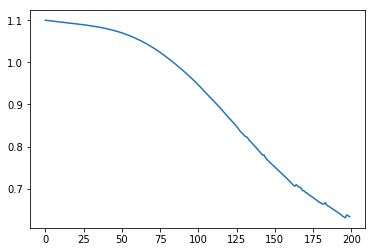

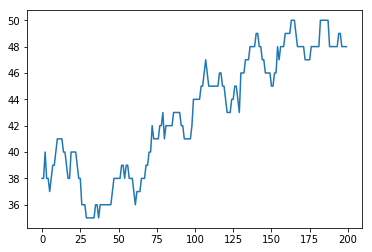

In [88]:
plt.plot(epoch_losses)
plt.show()
plt.plot(epoch_accuracies)
plt.show()

## Save model 

In [89]:
torch.save(model.state_dict(), "passive_mass_model.pt")

## Load model and evaluate

In [90]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("passive_mass_model.pt"))
model.eval()
model = model.cuda()

In [91]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [92]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.array([y.cpu().numpy() for x, y in val_loader]).reshape(-1)

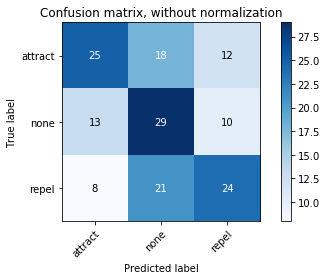

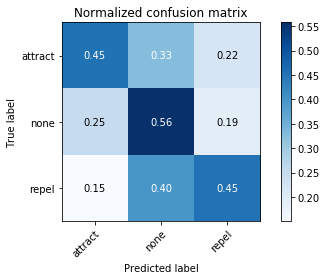

In [93]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)

# FORCE TRAINING 

## Read dataset and preprocess it

In [94]:
all_trials = read_dataset("passive_trials.h5")
train_loader, val_loader = prepare_dataset(all_trials, FORCE_CLASS_COLS, normalise=True)

## Define model, loss and optimizer

In [111]:
np.random.seed(62)
torch.manual_seed(72)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

input_dim = X_train.shape[-1]    # input dimension
first_hidden_dim = 12  # hidden layer dimension
second_hidden_dim = 6     # number of hidden layers
output_dim = 3   # output dimension

model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model = model.cuda()

error = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model and plot loss and accuracy

In [112]:
epoch_losses, epoch_accuracies = training_loop(model, optimizer, error, train_loader, val_loader, num_epochs=600)

  0%|          | 1/600 [00:00<04:33,  2.19it/s]

1.1081006526947021 tensor(34, device='cuda:0')


  0%|          | 2/600 [00:00<04:24,  2.26it/s]

1.1074135303497314 tensor(36, device='cuda:0')


  0%|          | 3/600 [00:01<04:22,  2.28it/s]

1.1067352294921875 tensor(36, device='cuda:0')


  1%|          | 4/600 [00:01<04:17,  2.32it/s]

1.1060655117034912 tensor(37, device='cuda:0')


  1%|          | 5/600 [00:02<04:14,  2.34it/s]

1.1054044961929321 tensor(38, device='cuda:0')


  1%|          | 6/600 [00:02<04:11,  2.36it/s]

1.1047518253326416 tensor(40, device='cuda:0')


  1%|          | 7/600 [00:02<04:06,  2.41it/s]

1.10410737991333 tensor(40, device='cuda:0')


  1%|▏         | 8/600 [00:03<04:05,  2.41it/s]

1.103470802307129 tensor(41, device='cuda:0')


  2%|▏         | 9/600 [00:03<03:50,  2.56it/s]

1.1028422117233276 tensor(41, device='cuda:0')


  2%|▏         | 10/600 [00:04<03:40,  2.68it/s]

1.1022212505340576 tensor(41, device='cuda:0')


  2%|▏         | 11/600 [00:04<03:33,  2.76it/s]

1.101607084274292 tensor(41, device='cuda:0')


  2%|▏         | 12/600 [00:04<03:27,  2.83it/s]

1.1009994745254517 tensor(42, device='cuda:0')


  2%|▏         | 13/600 [00:05<03:24,  2.88it/s]

1.100398063659668 tensor(42, device='cuda:0')


  2%|▏         | 14/600 [00:05<03:33,  2.75it/s]

1.0998021364212036 tensor(43, device='cuda:0')


  2%|▎         | 15/600 [00:05<03:40,  2.65it/s]

1.0992112159729004 tensor(43, device='cuda:0')


  3%|▎         | 16/600 [00:06<03:33,  2.74it/s]

1.0986248254776 tensor(43, device='cuda:0')


  3%|▎         | 17/600 [00:06<03:27,  2.81it/s]

1.0980421304702759 tensor(43, device='cuda:0')


  3%|▎         | 18/600 [00:06<03:23,  2.86it/s]

1.097462773323059 tensor(45, device='cuda:0')


  3%|▎         | 19/600 [00:07<03:32,  2.73it/s]

1.0968860387802124 tensor(44, device='cuda:0')


  3%|▎         | 20/600 [00:07<03:39,  2.64it/s]

1.096311330795288 tensor(43, device='cuda:0')


  4%|▎         | 21/600 [00:08<03:42,  2.60it/s]

1.0957379341125488 tensor(42, device='cuda:0')


  4%|▎         | 22/600 [00:08<03:34,  2.70it/s]

1.0951653718948364 tensor(42, device='cuda:0')


  4%|▍         | 23/600 [00:08<03:27,  2.78it/s]

1.0945926904678345 tensor(41, device='cuda:0')


  4%|▍         | 24/600 [00:09<03:34,  2.68it/s]

1.0940192937850952 tensor(41, device='cuda:0')


  4%|▍         | 25/600 [00:09<03:40,  2.61it/s]

1.0934447050094604 tensor(41, device='cuda:0')


  4%|▍         | 26/600 [00:09<03:32,  2.71it/s]

1.0928682088851929 tensor(40, device='cuda:0')


  4%|▍         | 27/600 [00:10<03:25,  2.78it/s]

1.0922890901565552 tensor(40, device='cuda:0')


  5%|▍         | 28/600 [00:10<03:33,  2.69it/s]

1.0917065143585205 tensor(40, device='cuda:0')


  5%|▍         | 29/600 [00:11<03:38,  2.61it/s]

1.0911195278167725 tensor(40, device='cuda:0')


  5%|▌         | 30/600 [00:11<03:30,  2.71it/s]

1.090527892112732 tensor(41, device='cuda:0')


  5%|▌         | 31/600 [00:11<03:35,  2.63it/s]

1.0899298191070557 tensor(41, device='cuda:0')


  5%|▌         | 32/600 [00:12<03:39,  2.59it/s]

1.089325189590454 tensor(41, device='cuda:0')


  6%|▌         | 33/600 [00:12<03:43,  2.54it/s]

1.0887126922607422 tensor(41, device='cuda:0')


  6%|▌         | 34/600 [00:12<03:45,  2.51it/s]

1.0880916118621826 tensor(41, device='cuda:0')


  6%|▌         | 35/600 [00:13<03:34,  2.63it/s]

1.0874601602554321 tensor(41, device='cuda:0')


  6%|▌         | 36/600 [00:13<03:27,  2.72it/s]

1.086817979812622 tensor(41, device='cuda:0')


  6%|▌         | 37/600 [00:14<03:32,  2.65it/s]

1.0861635208129883 tensor(41, device='cuda:0')


  6%|▋         | 38/600 [00:14<03:37,  2.58it/s]

1.0854957103729248 tensor(41, device='cuda:0')


  6%|▋         | 39/600 [00:14<03:28,  2.68it/s]

1.084812879562378 tensor(41, device='cuda:0')


  7%|▋         | 40/600 [00:15<03:34,  2.61it/s]

1.0841141939163208 tensor(41, device='cuda:0')


  7%|▋         | 41/600 [00:15<03:26,  2.70it/s]

1.083397626876831 tensor(41, device='cuda:0')


  7%|▋         | 42/600 [00:15<03:20,  2.78it/s]

1.0826621055603027 tensor(41, device='cuda:0')


  7%|▋         | 43/600 [00:16<03:28,  2.68it/s]

1.0819065570831299 tensor(41, device='cuda:0')


  7%|▋         | 44/600 [00:16<03:34,  2.60it/s]

1.0811293125152588 tensor(41, device='cuda:0')


  8%|▊         | 45/600 [00:17<03:36,  2.56it/s]

1.0803300142288208 tensor(41, device='cuda:0')


  8%|▊         | 46/600 [00:17<03:40,  2.52it/s]

1.0795071125030518 tensor(41, device='cuda:0')


  8%|▊         | 47/600 [00:17<03:41,  2.50it/s]

1.0786601305007935 tensor(41, device='cuda:0')


  8%|▊         | 48/600 [00:18<03:30,  2.62it/s]

1.0777884721755981 tensor(41, device='cuda:0')


  8%|▊         | 49/600 [00:18<03:30,  2.61it/s]

1.0768908262252808 tensor(41, device='cuda:0')


  8%|▊         | 50/600 [00:19<03:34,  2.57it/s]

1.075966238975525 tensor(41, device='cuda:0')


  8%|▊         | 51/600 [00:19<03:36,  2.54it/s]

1.0750138759613037 tensor(41, device='cuda:0')


  9%|▊         | 52/600 [00:19<03:27,  2.64it/s]

1.0740320682525635 tensor(41, device='cuda:0')


  9%|▉         | 53/600 [00:20<03:23,  2.69it/s]

1.07301926612854 tensor(40, device='cuda:0')


  9%|▉         | 54/600 [00:20<03:29,  2.61it/s]

1.0719739198684692 tensor(40, device='cuda:0')


  9%|▉         | 55/600 [00:20<03:32,  2.56it/s]

1.0708951950073242 tensor(41, device='cuda:0')


  9%|▉         | 56/600 [00:21<03:24,  2.66it/s]

1.069780707359314 tensor(41, device='cuda:0')


 10%|▉         | 57/600 [00:21<03:28,  2.60it/s]

1.0686302185058594 tensor(41, device='cuda:0')


 10%|▉         | 58/600 [00:22<03:32,  2.55it/s]

1.0674431324005127 tensor(40, device='cuda:0')


 10%|▉         | 59/600 [00:22<03:39,  2.47it/s]

1.0662205219268799 tensor(40, device='cuda:0')


 10%|█         | 60/600 [00:22<03:39,  2.46it/s]

1.0649627447128296 tensor(42, device='cuda:0')


 10%|█         | 61/600 [00:23<03:28,  2.58it/s]

1.0636708736419678 tensor(41, device='cuda:0')


 10%|█         | 62/600 [00:23<03:31,  2.54it/s]

1.062345266342163 tensor(41, device='cuda:0')


 10%|█         | 63/600 [00:24<03:22,  2.65it/s]

1.0609872341156006 tensor(40, device='cuda:0')


 11%|█         | 64/600 [00:24<03:26,  2.59it/s]

1.0595966577529907 tensor(40, device='cuda:0')


 11%|█         | 65/600 [00:24<03:29,  2.55it/s]

1.0581719875335693 tensor(41, device='cuda:0')


 11%|█         | 66/600 [00:25<03:21,  2.65it/s]

1.0567097663879395 tensor(40, device='cuda:0')


 11%|█         | 67/600 [00:25<03:25,  2.59it/s]

1.0552070140838623 tensor(40, device='cuda:0')


 11%|█▏        | 68/600 [00:25<03:18,  2.68it/s]

1.0536595582962036 tensor(40, device='cuda:0')


 12%|█▏        | 69/600 [00:26<03:22,  2.62it/s]

1.0520645380020142 tensor(40, device='cuda:0')


 12%|█▏        | 70/600 [00:26<03:16,  2.70it/s]

1.0504188537597656 tensor(38, device='cuda:0')


 12%|█▏        | 71/600 [00:27<03:21,  2.63it/s]

1.0487197637557983 tensor(38, device='cuda:0')


 12%|█▏        | 72/600 [00:27<03:25,  2.57it/s]

1.0469658374786377 tensor(38, device='cuda:0')


 12%|█▏        | 73/600 [00:28<03:37,  2.42it/s]

1.0451557636260986 tensor(38, device='cuda:0')


 12%|█▏        | 74/600 [00:28<03:25,  2.55it/s]

1.0432953834533691 tensor(38, device='cuda:0')


 12%|█▎        | 75/600 [00:28<03:27,  2.54it/s]

1.041394829750061 tensor(38, device='cuda:0')


 13%|█▎        | 76/600 [00:29<03:29,  2.50it/s]

1.0394647121429443 tensor(36, device='cuda:0')


 13%|█▎        | 77/600 [00:29<03:29,  2.49it/s]

1.0375036001205444 tensor(35, device='cuda:0')


 13%|█▎        | 78/600 [00:29<03:31,  2.47it/s]

1.035480260848999 tensor(35, device='cuda:0')


 13%|█▎        | 79/600 [00:30<03:30,  2.47it/s]

1.0333786010742188 tensor(36, device='cuda:0')


 13%|█▎        | 80/600 [00:30<03:30,  2.47it/s]

1.0312163829803467 tensor(36, device='cuda:0')


 14%|█▎        | 81/600 [00:31<03:20,  2.59it/s]

1.0290076732635498 tensor(37, device='cuda:0')


 14%|█▎        | 82/600 [00:31<03:22,  2.55it/s]

1.026747465133667 tensor(37, device='cuda:0')


 14%|█▍        | 83/600 [00:31<03:14,  2.66it/s]

1.0244297981262207 tensor(37, device='cuda:0')


 14%|█▍        | 84/600 [00:32<03:18,  2.60it/s]

1.0220667123794556 tensor(38, device='cuda:0')


 14%|█▍        | 85/600 [00:32<03:21,  2.55it/s]

1.0196599960327148 tensor(38, device='cuda:0')


 14%|█▍        | 86/600 [00:33<03:13,  2.65it/s]

1.0172004699707031 tensor(38, device='cuda:0')


 14%|█▍        | 87/600 [00:33<03:18,  2.58it/s]

1.014702320098877 tensor(38, device='cuda:0')


 15%|█▍        | 88/600 [00:33<03:20,  2.55it/s]

1.0121617317199707 tensor(38, device='cuda:0')


 15%|█▍        | 89/600 [00:34<03:23,  2.51it/s]

1.0095748901367188 tensor(37, device='cuda:0')


 15%|█▌        | 90/600 [00:34<03:25,  2.49it/s]

1.0069133043289185 tensor(37, device='cuda:0')


 15%|█▌        | 91/600 [00:35<03:15,  2.60it/s]

1.0041801929473877 tensor(38, device='cuda:0')


 15%|█▌        | 92/600 [00:35<03:18,  2.56it/s]

1.0014142990112305 tensor(37, device='cuda:0')


 16%|█▌        | 93/600 [00:35<03:10,  2.66it/s]

0.998592734336853 tensor(37, device='cuda:0')


 16%|█▌        | 94/600 [00:36<03:15,  2.59it/s]

0.9956825375556946 tensor(37, device='cuda:0')


 16%|█▌        | 95/600 [00:36<03:18,  2.55it/s]

0.9929336309432983 tensor(38, device='cuda:0')


 16%|█▌        | 96/600 [00:36<03:19,  2.53it/s]

0.9900396466255188 tensor(38, device='cuda:0')


 16%|█▌        | 97/600 [00:37<03:20,  2.51it/s]

0.9873854517936707 tensor(38, device='cuda:0')


 16%|█▋        | 98/600 [00:37<03:21,  2.49it/s]

0.9846914410591125 tensor(38, device='cuda:0')


 16%|█▋        | 99/600 [00:38<03:22,  2.47it/s]

0.9824603796005249 tensor(38, device='cuda:0')


 17%|█▋        | 100/600 [00:38<03:13,  2.59it/s]

0.9791857004165649 tensor(38, device='cuda:0')


 17%|█▋        | 101/600 [00:38<03:16,  2.54it/s]

0.9763728380203247 tensor(38, device='cuda:0')


 17%|█▋        | 102/600 [00:39<03:17,  2.52it/s]

0.9735042452812195 tensor(38, device='cuda:0')


 17%|█▋        | 103/600 [00:39<03:18,  2.51it/s]

0.9705805778503418 tensor(37, device='cuda:0')


 17%|█▋        | 104/600 [00:40<03:09,  2.61it/s]

0.9676077961921692 tensor(38, device='cuda:0')


 18%|█▊        | 105/600 [00:40<03:12,  2.57it/s]

0.9645835757255554 tensor(38, device='cuda:0')


 18%|█▊        | 106/600 [00:40<03:15,  2.53it/s]

0.9615005254745483 tensor(38, device='cuda:0')


 18%|█▊        | 107/600 [00:41<03:07,  2.63it/s]

0.9583584666252136 tensor(38, device='cuda:0')


 18%|█▊        | 108/600 [00:41<03:01,  2.71it/s]

0.9551620483398438 tensor(38, device='cuda:0')


 18%|█▊        | 109/600 [00:42<03:07,  2.62it/s]

0.9519098997116089 tensor(38, device='cuda:0')


 18%|█▊        | 110/600 [00:42<03:10,  2.57it/s]

0.9485969543457031 tensor(39, device='cuda:0')


 18%|█▊        | 111/600 [00:42<03:13,  2.53it/s]

0.9458330869674683 tensor(40, device='cuda:0')


 19%|█▊        | 112/600 [00:43<03:05,  2.63it/s]

0.9430786371231079 tensor(40, device='cuda:0')


 19%|█▉        | 113/600 [00:43<03:07,  2.59it/s]

0.9398192167282104 tensor(40, device='cuda:0')


 19%|█▉        | 114/600 [00:43<03:10,  2.55it/s]

0.9369946718215942 tensor(40, device='cuda:0')


 19%|█▉        | 115/600 [00:44<03:12,  2.52it/s]

0.9341557621955872 tensor(40, device='cuda:0')


 19%|█▉        | 116/600 [00:44<03:13,  2.50it/s]

0.9312801361083984 tensor(40, device='cuda:0')


 20%|█▉        | 117/600 [00:45<03:04,  2.61it/s]

0.9283732175827026 tensor(41, device='cuda:0')


 20%|█▉        | 118/600 [00:45<03:07,  2.57it/s]

0.9254143834114075 tensor(41, device='cuda:0')


 20%|█▉        | 119/600 [00:45<03:00,  2.66it/s]

0.9223644137382507 tensor(41, device='cuda:0')


 20%|██        | 120/600 [00:46<03:04,  2.60it/s]

0.9192038774490356 tensor(41, device='cuda:0')


 20%|██        | 121/600 [00:46<03:07,  2.55it/s]

0.9159640073776245 tensor(41, device='cuda:0')


 20%|██        | 122/600 [00:47<03:09,  2.53it/s]

0.9127515554428101 tensor(41, device='cuda:0')


 20%|██        | 123/600 [00:47<03:10,  2.50it/s]

0.909415602684021 tensor(40, device='cuda:0')


 21%|██        | 124/600 [00:47<03:10,  2.49it/s]

0.9060924649238586 tensor(40, device='cuda:0')


 21%|██        | 125/600 [00:48<03:11,  2.48it/s]

0.9027431607246399 tensor(40, device='cuda:0')


 21%|██        | 126/600 [00:48<03:02,  2.60it/s]

0.8992716073989868 tensor(40, device='cuda:0')


 21%|██        | 127/600 [00:49<03:05,  2.55it/s]

0.8957804441452026 tensor(38, device='cuda:0')


 21%|██▏       | 128/600 [00:49<02:57,  2.65it/s]

0.8921410441398621 tensor(38, device='cuda:0')


 22%|██▏       | 129/600 [00:49<03:02,  2.59it/s]

0.888180136680603 tensor(38, device='cuda:0')


 22%|██▏       | 130/600 [00:50<02:55,  2.68it/s]

0.8849101066589355 tensor(38, device='cuda:0')


 22%|██▏       | 131/600 [00:50<03:00,  2.61it/s]

0.8816421627998352 tensor(39, device='cuda:0')


 22%|██▏       | 132/600 [00:50<02:54,  2.69it/s]

0.8783507347106934 tensor(39, device='cuda:0')


 22%|██▏       | 133/600 [00:51<02:58,  2.62it/s]

0.8750349283218384 tensor(39, device='cuda:0')


 22%|██▏       | 134/600 [00:51<02:52,  2.70it/s]

0.8717104196548462 tensor(39, device='cuda:0')


 22%|██▎       | 135/600 [00:52<02:56,  2.64it/s]

0.8684088587760925 tensor(40, device='cuda:0')


 23%|██▎       | 136/600 [00:52<03:00,  2.58it/s]

0.8651022911071777 tensor(40, device='cuda:0')


 23%|██▎       | 137/600 [00:52<02:53,  2.67it/s]

0.8632708787918091 tensor(40, device='cuda:0')


 23%|██▎       | 138/600 [00:53<02:56,  2.61it/s]

0.8599268198013306 tensor(40, device='cuda:0')


 23%|██▎       | 139/600 [00:53<02:51,  2.69it/s]

0.8565249443054199 tensor(40, device='cuda:0')


 23%|██▎       | 140/600 [00:53<02:55,  2.62it/s]

0.852992057800293 tensor(40, device='cuda:0')


 24%|██▎       | 141/600 [00:54<02:49,  2.70it/s]

0.8494651913642883 tensor(40, device='cuda:0')


 24%|██▎       | 142/600 [00:54<02:54,  2.62it/s]

0.8454868197441101 tensor(40, device='cuda:0')


 24%|██▍       | 143/600 [00:55<02:49,  2.70it/s]

0.8418570756912231 tensor(39, device='cuda:0')


 24%|██▍       | 144/600 [00:55<02:54,  2.62it/s]

0.8386329412460327 tensor(39, device='cuda:0')


 24%|██▍       | 145/600 [00:55<02:50,  2.66it/s]

0.8355419039726257 tensor(40, device='cuda:0')


 24%|██▍       | 146/600 [00:56<02:46,  2.73it/s]

0.8324682116508484 tensor(39, device='cuda:0')


 24%|██▍       | 147/600 [00:56<02:51,  2.65it/s]

0.8293598890304565 tensor(39, device='cuda:0')


 25%|██▍       | 148/600 [00:57<02:55,  2.58it/s]

0.8261868357658386 tensor(39, device='cuda:0')


 25%|██▍       | 149/600 [00:57<02:57,  2.54it/s]

0.822972297668457 tensor(39, device='cuda:0')


 25%|██▌       | 150/600 [00:57<02:59,  2.51it/s]

0.8197640180587769 tensor(39, device='cuda:0')


 25%|██▌       | 151/600 [00:58<02:59,  2.50it/s]

0.8165626525878906 tensor(39, device='cuda:0')


 25%|██▌       | 152/600 [00:58<03:00,  2.48it/s]

0.813177227973938 tensor(39, device='cuda:0')


 26%|██▌       | 153/600 [00:59<03:00,  2.47it/s]

0.8094423413276672 tensor(39, device='cuda:0')


 26%|██▌       | 154/600 [00:59<02:52,  2.58it/s]

0.8056257367134094 tensor(39, device='cuda:0')


 26%|██▌       | 155/600 [00:59<02:55,  2.54it/s]

0.8024241328239441 tensor(39, device='cuda:0')


 26%|██▌       | 156/600 [01:00<02:48,  2.64it/s]

0.799224853515625 tensor(39, device='cuda:0')


 26%|██▌       | 157/600 [01:00<02:50,  2.59it/s]

0.7960125803947449 tensor(39, device='cuda:0')


 26%|██▋       | 158/600 [01:00<02:45,  2.67it/s]

0.792749285697937 tensor(39, device='cuda:0')


 26%|██▋       | 159/600 [01:01<02:43,  2.69it/s]

0.7894636392593384 tensor(38, device='cuda:0')


 27%|██▋       | 160/600 [01:01<02:44,  2.67it/s]

0.7861689925193787 tensor(40, device='cuda:0')


 27%|██▋       | 161/600 [01:02<02:52,  2.54it/s]

0.7828298211097717 tensor(40, device='cuda:0')


 27%|██▋       | 162/600 [01:02<02:58,  2.45it/s]

0.7793372869491577 tensor(41, device='cuda:0')


 27%|██▋       | 163/600 [01:02<03:02,  2.39it/s]

0.775571346282959 tensor(41, device='cuda:0')


 27%|██▋       | 164/600 [01:03<03:05,  2.35it/s]

0.7744442820549011 tensor(43, device='cuda:0')


 28%|██▊       | 165/600 [01:03<03:06,  2.33it/s]

0.7712165117263794 tensor(43, device='cuda:0')


 28%|██▊       | 166/600 [01:04<03:07,  2.31it/s]

0.7678594589233398 tensor(43, device='cuda:0')


 28%|██▊       | 167/600 [01:04<03:08,  2.30it/s]

0.7666209936141968 tensor(43, device='cuda:0')


 28%|██▊       | 168/600 [01:05<03:08,  2.29it/s]

0.7634226679801941 tensor(43, device='cuda:0')


 28%|██▊       | 169/600 [01:05<03:08,  2.29it/s]

0.7601563334465027 tensor(43, device='cuda:0')


 28%|██▊       | 170/600 [01:06<03:07,  2.29it/s]

0.7568320035934448 tensor(44, device='cuda:0')


 28%|██▊       | 171/600 [01:06<02:56,  2.43it/s]

0.7535518407821655 tensor(45, device='cuda:0')


 29%|██▊       | 172/600 [01:06<02:48,  2.54it/s]

0.7503064870834351 tensor(45, device='cuda:0')


 29%|██▉       | 173/600 [01:07<02:42,  2.62it/s]

0.7472282648086548 tensor(45, device='cuda:0')


 29%|██▉       | 174/600 [01:07<02:38,  2.69it/s]

0.7435563206672668 tensor(44, device='cuda:0')


 29%|██▉       | 175/600 [01:07<02:35,  2.74it/s]

0.7409769892692566 tensor(44, device='cuda:0')


 29%|██▉       | 176/600 [01:08<02:33,  2.77it/s]

0.7387216687202454 tensor(43, device='cuda:0')


 30%|██▉       | 177/600 [01:08<02:31,  2.80it/s]

0.7315205335617065 tensor(45, device='cuda:0')


 30%|██▉       | 178/600 [01:08<02:29,  2.82it/s]

0.7273168563842773 tensor(45, device='cuda:0')


 30%|██▉       | 179/600 [01:09<02:28,  2.83it/s]

0.7237523198127747 tensor(45, device='cuda:0')


 30%|███       | 180/600 [01:09<02:28,  2.84it/s]

0.7200272083282471 tensor(45, device='cuda:0')


 30%|███       | 181/600 [01:09<02:27,  2.84it/s]

0.7165495157241821 tensor(45, device='cuda:0')


 30%|███       | 182/600 [01:10<02:26,  2.84it/s]

0.7121051549911499 tensor(43, device='cuda:0')


 30%|███       | 183/600 [01:10<02:26,  2.85it/s]

0.7089164853096008 tensor(43, device='cuda:0')


 31%|███       | 184/600 [01:10<02:25,  2.85it/s]

0.705522358417511 tensor(43, device='cuda:0')


 31%|███       | 185/600 [01:11<02:25,  2.86it/s]

0.7019131183624268 tensor(43, device='cuda:0')


 31%|███       | 186/600 [01:11<02:24,  2.86it/s]

0.6984738111495972 tensor(44, device='cuda:0')


 31%|███       | 187/600 [01:11<02:24,  2.86it/s]

0.6952077150344849 tensor(43, device='cuda:0')


 31%|███▏      | 188/600 [01:12<02:29,  2.75it/s]

0.6917460560798645 tensor(43, device='cuda:0')


 32%|███▏      | 189/600 [01:12<02:34,  2.66it/s]

0.6886312365531921 tensor(43, device='cuda:0')


 32%|███▏      | 190/600 [01:13<02:31,  2.71it/s]

0.6858559846878052 tensor(43, device='cuda:0')


 32%|███▏      | 191/600 [01:13<02:28,  2.76it/s]

0.6828472018241882 tensor(43, device='cuda:0')


 32%|███▏      | 192/600 [01:13<02:26,  2.79it/s]

0.6801517605781555 tensor(42, device='cuda:0')


 32%|███▏      | 193/600 [01:14<02:25,  2.80it/s]

0.6777380704879761 tensor(42, device='cuda:0')


 32%|███▏      | 194/600 [01:14<02:24,  2.82it/s]

0.6780577898025513 tensor(43, device='cuda:0')


 32%|███▎      | 195/600 [01:14<02:30,  2.70it/s]

0.672308623790741 tensor(43, device='cuda:0')


 33%|███▎      | 196/600 [01:15<02:34,  2.61it/s]

0.6693140268325806 tensor(43, device='cuda:0')


 33%|███▎      | 197/600 [01:15<02:37,  2.56it/s]

0.6693627238273621 tensor(43, device='cuda:0')


 33%|███▎      | 198/600 [01:16<02:32,  2.64it/s]

0.6667085886001587 tensor(43, device='cuda:0')


 33%|███▎      | 199/600 [01:16<02:34,  2.59it/s]

0.6644582748413086 tensor(43, device='cuda:0')


 33%|███▎      | 200/600 [01:16<02:30,  2.67it/s]

0.6620094180107117 tensor(43, device='cuda:0')


 34%|███▎      | 201/600 [01:17<02:26,  2.72it/s]

0.6594354510307312 tensor(43, device='cuda:0')


 34%|███▎      | 202/600 [01:17<02:24,  2.76it/s]

0.6568810939788818 tensor(43, device='cuda:0')


 34%|███▍      | 203/600 [01:17<02:22,  2.79it/s]

0.6543875336647034 tensor(43, device='cuda:0')


 34%|███▍      | 204/600 [01:18<02:20,  2.81it/s]

0.6531857252120972 tensor(43, device='cuda:0')


 34%|███▍      | 205/600 [01:18<02:25,  2.72it/s]

0.6506797671318054 tensor(43, device='cuda:0')


 34%|███▍      | 206/600 [01:19<02:30,  2.61it/s]

0.6490649580955505 tensor(44, device='cuda:0')


 34%|███▍      | 207/600 [01:19<02:33,  2.56it/s]

0.6455825567245483 tensor(45, device='cuda:0')


 35%|███▍      | 208/600 [01:19<02:28,  2.64it/s]

0.6430676579475403 tensor(45, device='cuda:0')


 35%|███▍      | 209/600 [01:20<02:30,  2.61it/s]

0.640659511089325 tensor(45, device='cuda:0')


 35%|███▌      | 210/600 [01:20<02:25,  2.68it/s]

0.6381642818450928 tensor(45, device='cuda:0')


 35%|███▌      | 211/600 [01:20<02:22,  2.73it/s]

0.6357272267341614 tensor(45, device='cuda:0')


 35%|███▌      | 212/600 [01:21<02:29,  2.60it/s]

0.633489727973938 tensor(44, device='cuda:0')


 36%|███▌      | 213/600 [01:21<02:29,  2.58it/s]

0.6308689117431641 tensor(44, device='cuda:0')


 36%|███▌      | 214/600 [01:22<02:25,  2.66it/s]

0.6287384033203125 tensor(45, device='cuda:0')


 36%|███▌      | 215/600 [01:22<02:21,  2.72it/s]

0.6261223554611206 tensor(45, device='cuda:0')


 36%|███▌      | 216/600 [01:22<02:25,  2.63it/s]

0.6236299872398376 tensor(44, device='cuda:0')


 36%|███▌      | 217/600 [01:23<02:28,  2.58it/s]

0.621940553188324 tensor(45, device='cuda:0')


 36%|███▋      | 218/600 [01:23<02:24,  2.65it/s]

0.6181941032409668 tensor(45, device='cuda:0')


 36%|███▋      | 219/600 [01:23<02:20,  2.71it/s]

0.616326093673706 tensor(45, device='cuda:0')


 37%|███▋      | 220/600 [01:24<02:18,  2.75it/s]

0.6141186952590942 tensor(45, device='cuda:0')


 37%|███▋      | 221/600 [01:24<02:16,  2.78it/s]

0.6120012402534485 tensor(45, device='cuda:0')


 37%|███▋      | 222/600 [01:25<02:21,  2.67it/s]

0.6081451177597046 tensor(46, device='cuda:0')


 37%|███▋      | 223/600 [01:25<02:24,  2.61it/s]

0.6069976687431335 tensor(45, device='cuda:0')


 37%|███▋      | 224/600 [01:25<02:20,  2.67it/s]

0.6059876680374146 tensor(45, device='cuda:0')


 38%|███▊      | 225/600 [01:26<02:17,  2.72it/s]

0.6084040403366089 tensor(45, device='cuda:0')


 38%|███▊      | 226/600 [01:26<02:15,  2.76it/s]

0.607958197593689 tensor(45, device='cuda:0')


 38%|███▊      | 227/600 [01:26<02:20,  2.66it/s]

0.60840904712677 tensor(44, device='cuda:0')


 38%|███▊      | 228/600 [01:27<02:23,  2.59it/s]

0.6050727367401123 tensor(43, device='cuda:0')


 38%|███▊      | 229/600 [01:27<02:25,  2.55it/s]

0.6047104597091675 tensor(43, device='cuda:0')


 38%|███▊      | 230/600 [01:28<02:20,  2.63it/s]

0.6068901419639587 tensor(44, device='cuda:0')


 38%|███▊      | 231/600 [01:28<02:17,  2.69it/s]

0.603960394859314 tensor(44, device='cuda:0')


 39%|███▊      | 232/600 [01:28<02:14,  2.73it/s]

0.6027541160583496 tensor(44, device='cuda:0')


 39%|███▉      | 233/600 [01:29<02:12,  2.77it/s]

0.601317822933197 tensor(45, device='cuda:0')


 39%|███▉      | 234/600 [01:29<02:10,  2.80it/s]

0.5995635986328125 tensor(45, device='cuda:0')


 39%|███▉      | 235/600 [01:29<02:09,  2.81it/s]

0.5981130003929138 tensor(46, device='cuda:0')


 39%|███▉      | 236/600 [01:30<02:09,  2.82it/s]

0.5969305038452148 tensor(46, device='cuda:0')


 40%|███▉      | 237/600 [01:30<02:08,  2.83it/s]

0.5955817103385925 tensor(47, device='cuda:0')


 40%|███▉      | 238/600 [01:30<02:13,  2.71it/s]

0.5942994356155396 tensor(47, device='cuda:0')


 40%|███▉      | 239/600 [01:31<02:17,  2.63it/s]

0.5931397676467896 tensor(47, device='cuda:0')


 40%|████      | 240/600 [01:31<02:13,  2.69it/s]

0.5918192267417908 tensor(47, device='cuda:0')


 40%|████      | 241/600 [01:32<02:11,  2.73it/s]

0.590538501739502 tensor(46, device='cuda:0')


 40%|████      | 242/600 [01:32<02:09,  2.77it/s]

0.5893634557723999 tensor(47, device='cuda:0')


 40%|████      | 243/600 [01:32<02:07,  2.80it/s]

0.5881216526031494 tensor(47, device='cuda:0')


 41%|████      | 244/600 [01:33<02:12,  2.69it/s]

0.5867618322372437 tensor(47, device='cuda:0')


 41%|████      | 245/600 [01:33<02:15,  2.61it/s]

0.585608720779419 tensor(47, device='cuda:0')


 41%|████      | 246/600 [01:33<02:11,  2.68it/s]

0.5842086672782898 tensor(47, device='cuda:0')


 41%|████      | 247/600 [01:34<02:14,  2.62it/s]

0.5831326842308044 tensor(47, device='cuda:0')


 41%|████▏     | 248/600 [01:34<02:11,  2.69it/s]

0.5820372700691223 tensor(47, device='cuda:0')


 42%|████▏     | 249/600 [01:35<02:08,  2.73it/s]

0.5804206728935242 tensor(47, device='cuda:0')


 42%|████▏     | 250/600 [01:35<02:06,  2.77it/s]

0.5793873071670532 tensor(47, device='cuda:0')


 42%|████▏     | 251/600 [01:35<02:10,  2.67it/s]

0.5770384669303894 tensor(47, device='cuda:0')


 42%|████▏     | 252/600 [01:36<02:13,  2.60it/s]

0.5771271586418152 tensor(46, device='cuda:0')


 42%|████▏     | 253/600 [01:36<02:09,  2.67it/s]

0.5792135000228882 tensor(46, device='cuda:0')


 42%|████▏     | 254/600 [01:36<02:06,  2.73it/s]

0.5781072974205017 tensor(46, device='cuda:0')


 42%|████▎     | 255/600 [01:37<02:04,  2.76it/s]

0.5766401886940002 tensor(46, device='cuda:0')


 43%|████▎     | 256/600 [01:37<02:03,  2.79it/s]

0.5759608149528503 tensor(45, device='cuda:0')


 43%|████▎     | 257/600 [01:37<02:02,  2.81it/s]

0.5749562978744507 tensor(46, device='cuda:0')


 43%|████▎     | 258/600 [01:38<02:01,  2.82it/s]

0.5735247731208801 tensor(46, device='cuda:0')


 43%|████▎     | 259/600 [01:38<02:00,  2.83it/s]

0.5722297430038452 tensor(46, device='cuda:0')


 43%|████▎     | 260/600 [01:39<02:04,  2.73it/s]

0.5712628960609436 tensor(46, device='cuda:0')


 44%|████▎     | 261/600 [01:39<02:02,  2.77it/s]

0.5700830817222595 tensor(46, device='cuda:0')


 44%|████▎     | 262/600 [01:39<02:01,  2.79it/s]

0.5687150955200195 tensor(46, device='cuda:0')


 44%|████▍     | 263/600 [01:40<02:00,  2.81it/s]

0.5674247145652771 tensor(46, device='cuda:0')


 44%|████▍     | 264/600 [01:40<01:59,  2.82it/s]

0.5663802027702332 tensor(46, device='cuda:0')


 44%|████▍     | 265/600 [01:40<02:04,  2.70it/s]

0.5648413896560669 tensor(46, device='cuda:0')


 44%|████▍     | 266/600 [01:41<02:07,  2.62it/s]

0.5639746785163879 tensor(46, device='cuda:0')


 44%|████▍     | 267/600 [01:41<02:09,  2.57it/s]

0.5629516839981079 tensor(46, device='cuda:0')


 45%|████▍     | 268/600 [01:42<02:11,  2.53it/s]

0.5618183016777039 tensor(46, device='cuda:0')


 45%|████▍     | 269/600 [01:42<02:06,  2.62it/s]

0.5607357621192932 tensor(46, device='cuda:0')


 45%|████▌     | 270/600 [01:42<02:08,  2.57it/s]

0.5595852732658386 tensor(46, device='cuda:0')


 45%|████▌     | 271/600 [01:43<02:09,  2.54it/s]

0.5585018396377563 tensor(46, device='cuda:0')


 45%|████▌     | 272/600 [01:43<02:05,  2.62it/s]

0.5573858022689819 tensor(46, device='cuda:0')


 46%|████▌     | 273/600 [01:43<02:01,  2.69it/s]

0.5562062859535217 tensor(46, device='cuda:0')


 46%|████▌     | 274/600 [01:44<01:59,  2.73it/s]

0.5549435615539551 tensor(47, device='cuda:0')


 46%|████▌     | 275/600 [01:44<01:57,  2.77it/s]

0.5563428401947021 tensor(47, device='cuda:0')


 46%|████▌     | 276/600 [01:45<01:55,  2.79it/s]

0.5497487783432007 tensor(47, device='cuda:0')


 46%|████▌     | 277/600 [01:45<01:54,  2.81it/s]

0.5486770272254944 tensor(47, device='cuda:0')


 46%|████▋     | 278/600 [01:45<01:59,  2.70it/s]

0.5477321743965149 tensor(48, device='cuda:0')


 46%|████▋     | 279/600 [01:46<02:02,  2.61it/s]

0.5467370748519897 tensor(48, device='cuda:0')


 47%|████▋     | 280/600 [01:46<01:59,  2.68it/s]

0.5457910299301147 tensor(48, device='cuda:0')


 47%|████▋     | 281/600 [01:46<02:01,  2.63it/s]

0.5446087121963501 tensor(48, device='cuda:0')


 47%|████▋     | 282/600 [01:47<01:58,  2.69it/s]

0.5470842719078064 tensor(48, device='cuda:0')


 47%|████▋     | 283/600 [01:47<01:55,  2.74it/s]

0.5425158739089966 tensor(48, device='cuda:0')


 47%|████▋     | 284/600 [01:48<01:54,  2.77it/s]

0.5415016412734985 tensor(48, device='cuda:0')


 48%|████▊     | 285/600 [01:48<01:52,  2.79it/s]

0.5404097437858582 tensor(48, device='cuda:0')


 48%|████▊     | 286/600 [01:48<01:51,  2.81it/s]

0.539445698261261 tensor(48, device='cuda:0')


 48%|████▊     | 287/600 [01:49<01:55,  2.72it/s]

0.538414478302002 tensor(48, device='cuda:0')


 48%|████▊     | 288/600 [01:49<01:53,  2.75it/s]

0.5373859405517578 tensor(49, device='cuda:0')


 48%|████▊     | 289/600 [01:49<01:51,  2.78it/s]

0.5362626314163208 tensor(49, device='cuda:0')


 48%|████▊     | 290/600 [01:50<01:50,  2.80it/s]

0.5352097749710083 tensor(50, device='cuda:0')


 48%|████▊     | 291/600 [01:50<01:54,  2.70it/s]

0.5341657400131226 tensor(50, device='cuda:0')


 49%|████▊     | 292/600 [01:50<01:57,  2.62it/s]

0.5330603718757629 tensor(49, device='cuda:0')


 49%|████▉     | 293/600 [01:51<01:54,  2.68it/s]

0.5318703055381775 tensor(49, device='cuda:0')


 49%|████▉     | 294/600 [01:51<01:52,  2.73it/s]

0.5289358496665955 tensor(49, device='cuda:0')


 49%|████▉     | 295/600 [01:52<01:50,  2.76it/s]

0.5266612768173218 tensor(49, device='cuda:0')


 49%|████▉     | 296/600 [01:52<01:48,  2.79it/s]

0.5260000824928284 tensor(49, device='cuda:0')


 50%|████▉     | 297/600 [01:52<01:47,  2.81it/s]

0.5247915387153625 tensor(48, device='cuda:0')


 50%|████▉     | 298/600 [01:53<01:52,  2.70it/s]

0.5234853029251099 tensor(48, device='cuda:0')


 50%|████▉     | 299/600 [01:53<01:55,  2.61it/s]

0.5226248502731323 tensor(48, device='cuda:0')


 50%|█████     | 300/600 [01:53<01:56,  2.58it/s]

0.5214323997497559 tensor(47, device='cuda:0')


 50%|█████     | 301/600 [01:54<01:53,  2.63it/s]

0.5202089548110962 tensor(47, device='cuda:0')


 50%|█████     | 302/600 [01:54<01:50,  2.69it/s]

0.5189789533615112 tensor(47, device='cuda:0')


 50%|█████     | 303/600 [01:55<01:48,  2.74it/s]

0.5179922580718994 tensor(46, device='cuda:0')


 51%|█████     | 304/600 [01:55<01:50,  2.68it/s]

0.5168892741203308 tensor(46, device='cuda:0')


 51%|█████     | 305/600 [01:55<01:53,  2.60it/s]

0.5157418251037598 tensor(46, device='cuda:0')


 51%|█████     | 306/600 [01:56<01:54,  2.56it/s]

0.5146265029907227 tensor(46, device='cuda:0')


 51%|█████     | 307/600 [01:56<01:56,  2.52it/s]

0.5134148597717285 tensor(46, device='cuda:0')


 51%|█████▏    | 308/600 [01:56<01:51,  2.61it/s]

0.5121455192565918 tensor(47, device='cuda:0')


 52%|█████▏    | 309/600 [01:57<01:48,  2.68it/s]

0.511828601360321 tensor(47, device='cuda:0')


 52%|█████▏    | 310/600 [01:57<01:56,  2.50it/s]

0.5103518962860107 tensor(47, device='cuda:0')


 52%|█████▏    | 311/600 [01:58<01:51,  2.59it/s]

0.5086833238601685 tensor(47, device='cuda:0')


 52%|█████▏    | 312/600 [01:58<01:48,  2.67it/s]

0.5061317086219788 tensor(48, device='cuda:0')


 52%|█████▏    | 313/600 [01:58<01:45,  2.72it/s]

0.5066849589347839 tensor(46, device='cuda:0')


 52%|█████▏    | 314/600 [01:59<01:43,  2.76it/s]

0.510811984539032 tensor(46, device='cuda:0')


 52%|█████▎    | 315/600 [01:59<01:46,  2.68it/s]

0.5147000551223755 tensor(45, device='cuda:0')


 53%|█████▎    | 316/600 [01:59<01:44,  2.73it/s]

0.5165466070175171 tensor(46, device='cuda:0')


 53%|█████▎    | 317/600 [02:00<01:42,  2.77it/s]

0.5182717442512512 tensor(46, device='cuda:0')


 53%|█████▎    | 318/600 [02:00<01:41,  2.79it/s]

0.517512857913971 tensor(46, device='cuda:0')


 53%|█████▎    | 319/600 [02:01<01:44,  2.68it/s]

0.5139039754867554 tensor(46, device='cuda:0')


 53%|█████▎    | 320/600 [02:01<01:47,  2.61it/s]

0.5132051706314087 tensor(47, device='cuda:0')


 54%|█████▎    | 321/600 [02:01<01:48,  2.58it/s]

0.5132113695144653 tensor(47, device='cuda:0')


 54%|█████▎    | 322/600 [02:02<01:44,  2.65it/s]

0.5084691047668457 tensor(47, device='cuda:0')


 54%|█████▍    | 323/600 [02:02<01:43,  2.68it/s]

0.5001737475395203 tensor(48, device='cuda:0')


 54%|█████▍    | 324/600 [02:03<01:48,  2.55it/s]

0.4998902678489685 tensor(48, device='cuda:0')


 54%|█████▍    | 325/600 [02:03<01:51,  2.47it/s]

0.49504557251930237 tensor(47, device='cuda:0')


 54%|█████▍    | 326/600 [02:03<01:54,  2.40it/s]

0.4946655333042145 tensor(46, device='cuda:0')


 55%|█████▍    | 327/600 [02:04<01:55,  2.36it/s]

0.4960384964942932 tensor(46, device='cuda:0')


 55%|█████▍    | 328/600 [02:04<01:55,  2.36it/s]

0.5045989751815796 tensor(46, device='cuda:0')


 55%|█████▍    | 329/600 [02:05<01:55,  2.34it/s]

0.5056205987930298 tensor(46, device='cuda:0')


 55%|█████▌    | 330/600 [02:05<01:55,  2.33it/s]

0.506313145160675 tensor(46, device='cuda:0')


 55%|█████▌    | 331/600 [02:06<01:54,  2.36it/s]

0.5115543603897095 tensor(46, device='cuda:0')


 55%|█████▌    | 332/600 [02:06<01:54,  2.33it/s]

0.5143728852272034 tensor(47, device='cuda:0')


 56%|█████▌    | 333/600 [02:06<01:55,  2.31it/s]

0.5134115815162659 tensor(47, device='cuda:0')


 56%|█████▌    | 334/600 [02:07<01:55,  2.30it/s]

0.5114317536354065 tensor(46, device='cuda:0')


 56%|█████▌    | 335/600 [02:07<01:54,  2.32it/s]

0.5103737711906433 tensor(46, device='cuda:0')


 56%|█████▌    | 336/600 [02:08<01:54,  2.30it/s]

0.505609929561615 tensor(45, device='cuda:0')


 56%|█████▌    | 337/600 [02:08<01:54,  2.30it/s]

0.5077402591705322 tensor(45, device='cuda:0')


 56%|█████▋    | 338/600 [02:09<01:53,  2.32it/s]

0.506669282913208 tensor(45, device='cuda:0')


 56%|█████▋    | 339/600 [02:09<01:50,  2.35it/s]

0.5057116150856018 tensor(45, device='cuda:0')


 57%|█████▋    | 340/600 [02:09<01:50,  2.34it/s]

0.5048494935035706 tensor(46, device='cuda:0')


 57%|█████▋    | 341/600 [02:10<01:46,  2.44it/s]

0.5038711428642273 tensor(46, device='cuda:0')


 57%|█████▋    | 342/600 [02:10<01:41,  2.53it/s]

0.5030991435050964 tensor(46, device='cuda:0')


 57%|█████▋    | 343/600 [02:11<01:44,  2.46it/s]

0.5021738409996033 tensor(46, device='cuda:0')


 57%|█████▋    | 344/600 [02:11<01:45,  2.42it/s]

0.5008249878883362 tensor(46, device='cuda:0')


 57%|█████▊    | 345/600 [02:11<01:44,  2.43it/s]

0.499683678150177 tensor(46, device='cuda:0')


 58%|█████▊    | 346/600 [02:12<01:44,  2.43it/s]

0.49859970808029175 tensor(46, device='cuda:0')


 58%|█████▊    | 347/600 [02:12<01:43,  2.44it/s]

0.497994601726532 tensor(46, device='cuda:0')


 58%|█████▊    | 348/600 [02:13<01:43,  2.44it/s]

0.4976170063018799 tensor(46, device='cuda:0')


 58%|█████▊    | 349/600 [02:13<01:43,  2.44it/s]

0.5001410245895386 tensor(46, device='cuda:0')


 58%|█████▊    | 350/600 [02:13<01:38,  2.54it/s]

0.501900851726532 tensor(46, device='cuda:0')


 58%|█████▊    | 351/600 [02:14<01:38,  2.52it/s]

0.5085011720657349 tensor(46, device='cuda:0')


 59%|█████▊    | 352/600 [02:14<01:39,  2.49it/s]

0.5095211267471313 tensor(46, device='cuda:0')


 59%|█████▉    | 353/600 [02:15<01:42,  2.41it/s]

0.5134706497192383 tensor(46, device='cuda:0')


 59%|█████▉    | 354/600 [02:15<01:43,  2.37it/s]

0.5154288411140442 tensor(46, device='cuda:0')


 59%|█████▉    | 355/600 [02:16<01:44,  2.35it/s]

0.5159245133399963 tensor(47, device='cuda:0')


 59%|█████▉    | 356/600 [02:16<01:42,  2.39it/s]

0.5196841955184937 tensor(45, device='cuda:0')


 60%|█████▉    | 357/600 [02:16<01:40,  2.41it/s]

0.5262986421585083 tensor(45, device='cuda:0')


 60%|█████▉    | 358/600 [02:17<01:40,  2.42it/s]

0.5275231599807739 tensor(45, device='cuda:0')


 60%|█████▉    | 359/600 [02:17<01:40,  2.39it/s]

0.5252545475959778 tensor(45, device='cuda:0')


 60%|██████    | 360/600 [02:18<01:41,  2.36it/s]

0.5287688970565796 tensor(46, device='cuda:0')


 60%|██████    | 361/600 [02:18<01:39,  2.39it/s]

0.5200177431106567 tensor(46, device='cuda:0')


 60%|██████    | 362/600 [02:18<01:35,  2.50it/s]

0.5164204835891724 tensor(46, device='cuda:0')


 60%|██████    | 363/600 [02:19<01:37,  2.43it/s]

0.515823483467102 tensor(46, device='cuda:0')


 61%|██████    | 364/600 [02:19<01:37,  2.41it/s]

0.5153777003288269 tensor(47, device='cuda:0')


 61%|██████    | 365/600 [02:20<01:39,  2.37it/s]

0.5236320495605469 tensor(48, device='cuda:0')


 61%|██████    | 366/600 [02:20<01:39,  2.35it/s]

0.523110032081604 tensor(48, device='cuda:0')


 61%|██████    | 367/600 [02:21<01:39,  2.33it/s]

0.521439790725708 tensor(48, device='cuda:0')


 61%|██████▏   | 368/600 [02:21<01:39,  2.32it/s]

0.5197653770446777 tensor(48, device='cuda:0')


 62%|██████▏   | 369/600 [02:21<01:38,  2.35it/s]

0.5173044204711914 tensor(48, device='cuda:0')


 62%|██████▏   | 370/600 [02:22<01:38,  2.33it/s]

0.515611469745636 tensor(48, device='cuda:0')


 62%|██████▏   | 371/600 [02:22<01:38,  2.33it/s]

0.5146086812019348 tensor(48, device='cuda:0')


 62%|██████▏   | 372/600 [02:23<01:36,  2.36it/s]

0.513707160949707 tensor(48, device='cuda:0')


 62%|██████▏   | 373/600 [02:23<01:31,  2.49it/s]

0.5126321315765381 tensor(48, device='cuda:0')


 62%|██████▏   | 374/600 [02:23<01:27,  2.59it/s]

0.5114399194717407 tensor(48, device='cuda:0')


 62%|██████▎   | 375/600 [02:24<01:24,  2.66it/s]

0.5102365612983704 tensor(47, device='cuda:0')


 63%|██████▎   | 376/600 [02:24<01:22,  2.72it/s]

0.5089753866195679 tensor(46, device='cuda:0')


 63%|██████▎   | 377/600 [02:24<01:20,  2.76it/s]

0.5075832009315491 tensor(45, device='cuda:0')


 63%|██████▎   | 378/600 [02:25<01:19,  2.78it/s]

0.506203293800354 tensor(45, device='cuda:0')


 63%|██████▎   | 379/600 [02:25<01:18,  2.81it/s]

0.5050753355026245 tensor(45, device='cuda:0')


 63%|██████▎   | 380/600 [02:25<01:17,  2.82it/s]

0.5034098625183105 tensor(45, device='cuda:0')


 64%|██████▎   | 381/600 [02:26<01:17,  2.84it/s]

0.502122163772583 tensor(45, device='cuda:0')


 64%|██████▎   | 382/600 [02:26<01:16,  2.84it/s]

0.5008987188339233 tensor(45, device='cuda:0')


 64%|██████▍   | 383/600 [02:27<01:16,  2.85it/s]

0.4998432695865631 tensor(45, device='cuda:0')


 64%|██████▍   | 384/600 [02:27<01:15,  2.85it/s]

0.49811410903930664 tensor(45, device='cuda:0')


 64%|██████▍   | 385/600 [02:27<01:15,  2.85it/s]

0.49606114625930786 tensor(45, device='cuda:0')


 64%|██████▍   | 386/600 [02:28<01:14,  2.86it/s]

0.4945729374885559 tensor(45, device='cuda:0')


 64%|██████▍   | 387/600 [02:28<01:17,  2.73it/s]

0.49296799302101135 tensor(45, device='cuda:0')


 65%|██████▍   | 388/600 [02:28<01:16,  2.77it/s]

0.49169445037841797 tensor(45, device='cuda:0')


 65%|██████▍   | 389/600 [02:29<01:15,  2.80it/s]

0.49089187383651733 tensor(45, device='cuda:0')


 65%|██████▌   | 390/600 [02:29<01:14,  2.81it/s]

0.4898678660392761 tensor(45, device='cuda:0')


 65%|██████▌   | 391/600 [02:29<01:13,  2.83it/s]

0.48877429962158203 tensor(45, device='cuda:0')


 65%|██████▌   | 392/600 [02:30<01:13,  2.84it/s]

0.48767414689064026 tensor(45, device='cuda:0')


 66%|██████▌   | 393/600 [02:30<01:12,  2.84it/s]

0.4863753318786621 tensor(45, device='cuda:0')


 66%|██████▌   | 394/600 [02:30<01:12,  2.85it/s]

0.4808809757232666 tensor(45, device='cuda:0')


 66%|██████▌   | 395/600 [02:31<01:15,  2.73it/s]

0.47988075017929077 tensor(44, device='cuda:0')


 66%|██████▌   | 396/600 [02:31<01:14,  2.75it/s]

0.47897228598594666 tensor(44, device='cuda:0')


 66%|██████▌   | 397/600 [02:32<01:18,  2.59it/s]

0.4780137538909912 tensor(44, device='cuda:0')


 66%|██████▋   | 398/600 [02:32<01:21,  2.48it/s]

0.47721990942955017 tensor(44, device='cuda:0')


 66%|██████▋   | 399/600 [02:33<01:23,  2.42it/s]

0.4766016900539398 tensor(44, device='cuda:0')


 67%|██████▋   | 400/600 [02:33<01:24,  2.38it/s]

0.47597503662109375 tensor(44, device='cuda:0')


 67%|██████▋   | 401/600 [02:33<01:24,  2.35it/s]

0.47524523735046387 tensor(44, device='cuda:0')


 67%|██████▋   | 402/600 [02:34<01:24,  2.34it/s]

0.47471126914024353 tensor(44, device='cuda:0')


 67%|██████▋   | 403/600 [02:34<01:24,  2.32it/s]

0.4739469885826111 tensor(44, device='cuda:0')


 67%|██████▋   | 404/600 [02:35<01:24,  2.32it/s]

0.4735099673271179 tensor(44, device='cuda:0')


 68%|██████▊   | 405/600 [02:35<01:24,  2.30it/s]

0.47272157669067383 tensor(44, device='cuda:0')


 68%|██████▊   | 406/600 [02:36<01:22,  2.34it/s]

0.4722301959991455 tensor(44, device='cuda:0')


 68%|██████▊   | 407/600 [02:36<01:21,  2.37it/s]

0.4716462194919586 tensor(44, device='cuda:0')


 68%|██████▊   | 408/600 [02:36<01:17,  2.49it/s]

0.47077685594558716 tensor(44, device='cuda:0')


 68%|██████▊   | 409/600 [02:37<01:17,  2.46it/s]

0.4698379635810852 tensor(44, device='cuda:0')


 68%|██████▊   | 410/600 [02:37<01:17,  2.45it/s]

0.4677318036556244 tensor(44, device='cuda:0')


 68%|██████▊   | 411/600 [02:37<01:14,  2.55it/s]

0.4653836786746979 tensor(44, device='cuda:0')


 69%|██████▊   | 412/600 [02:38<01:14,  2.52it/s]

0.464791864156723 tensor(44, device='cuda:0')


 69%|██████▉   | 413/600 [02:38<01:11,  2.60it/s]

0.4641819894313812 tensor(44, device='cuda:0')


 69%|██████▉   | 414/600 [02:39<01:12,  2.56it/s]

0.4635990262031555 tensor(44, device='cuda:0')


 69%|██████▉   | 415/600 [02:39<01:13,  2.52it/s]

0.46306324005126953 tensor(44, device='cuda:0')


 69%|██████▉   | 416/600 [02:39<01:13,  2.50it/s]

0.4623992443084717 tensor(44, device='cuda:0')


 70%|██████▉   | 417/600 [02:40<01:13,  2.48it/s]

0.46188703179359436 tensor(44, device='cuda:0')


 70%|██████▉   | 418/600 [02:40<01:13,  2.47it/s]

0.46130552887916565 tensor(44, device='cuda:0')


 70%|██████▉   | 419/600 [02:41<01:10,  2.57it/s]

0.4607504904270172 tensor(44, device='cuda:0')


 70%|███████   | 420/600 [02:41<01:11,  2.53it/s]

0.46032923460006714 tensor(44, device='cuda:0')


 70%|███████   | 421/600 [02:41<01:11,  2.50it/s]

0.4599139094352722 tensor(44, device='cuda:0')


 70%|███████   | 422/600 [02:42<01:08,  2.60it/s]

0.4592321813106537 tensor(44, device='cuda:0')


 70%|███████   | 423/600 [02:42<01:09,  2.55it/s]

0.4586248993873596 tensor(44, device='cuda:0')


 71%|███████   | 424/600 [02:43<01:07,  2.62it/s]

0.4582045078277588 tensor(44, device='cuda:0')


 71%|███████   | 425/600 [02:43<01:05,  2.68it/s]

0.45777377486228943 tensor(44, device='cuda:0')


 71%|███████   | 426/600 [02:43<01:06,  2.61it/s]

0.4572387635707855 tensor(44, device='cuda:0')


 71%|███████   | 427/600 [02:44<01:04,  2.67it/s]

0.4567558169364929 tensor(44, device='cuda:0')


 71%|███████▏  | 428/600 [02:44<01:06,  2.60it/s]

0.4562755227088928 tensor(44, device='cuda:0')


 72%|███████▏  | 429/600 [02:45<01:07,  2.54it/s]

0.45579180121421814 tensor(44, device='cuda:0')


 72%|███████▏  | 430/600 [02:45<01:07,  2.51it/s]

0.455322802066803 tensor(44, device='cuda:0')


 72%|███████▏  | 431/600 [02:45<01:05,  2.60it/s]

0.45484113693237305 tensor(44, device='cuda:0')


 72%|███████▏  | 432/600 [02:46<01:05,  2.55it/s]

0.45437687635421753 tensor(44, device='cuda:0')


 72%|███████▏  | 433/600 [02:46<01:06,  2.52it/s]

0.4539056420326233 tensor(44, device='cuda:0')


 72%|███████▏  | 434/600 [02:47<01:06,  2.50it/s]

0.4534476697444916 tensor(44, device='cuda:0')


 72%|███████▎  | 435/600 [02:47<01:06,  2.47it/s]

0.4529810845851898 tensor(44, device='cuda:0')


 73%|███████▎  | 436/600 [02:47<01:06,  2.46it/s]

0.4525233805179596 tensor(44, device='cuda:0')


 73%|███████▎  | 437/600 [02:48<01:06,  2.46it/s]

0.4520716071128845 tensor(45, device='cuda:0')


 73%|███████▎  | 438/600 [02:48<01:03,  2.54it/s]

0.4516167640686035 tensor(45, device='cuda:0')


 73%|███████▎  | 439/600 [02:49<01:04,  2.51it/s]

0.4511590003967285 tensor(45, device='cuda:0')


 73%|███████▎  | 440/600 [02:49<01:01,  2.59it/s]

0.45071330666542053 tensor(45, device='cuda:0')


 74%|███████▎  | 441/600 [02:49<01:02,  2.55it/s]

0.4502841532230377 tensor(45, device='cuda:0')


 74%|███████▎  | 442/600 [02:50<01:00,  2.61it/s]

0.4497396945953369 tensor(45, device='cuda:0')


 74%|███████▍  | 443/600 [02:50<01:01,  2.55it/s]

0.4492920935153961 tensor(45, device='cuda:0')


 74%|███████▍  | 444/600 [02:50<01:01,  2.52it/s]

0.44895511865615845 tensor(45, device='cuda:0')


 74%|███████▍  | 445/600 [02:51<01:02,  2.48it/s]

0.44848865270614624 tensor(45, device='cuda:0')


 74%|███████▍  | 446/600 [02:51<01:03,  2.42it/s]

0.4479694962501526 tensor(45, device='cuda:0')


 74%|███████▍  | 447/600 [02:52<01:04,  2.38it/s]

0.4475458264350891 tensor(45, device='cuda:0')


 75%|███████▍  | 448/600 [02:52<01:04,  2.35it/s]

0.44703754782676697 tensor(45, device='cuda:0')


 75%|███████▍  | 449/600 [02:53<01:05,  2.32it/s]

0.44654956459999084 tensor(45, device='cuda:0')


 75%|███████▌  | 450/600 [02:53<01:04,  2.31it/s]

0.44597259163856506 tensor(45, device='cuda:0')


 75%|███████▌  | 451/600 [02:54<01:04,  2.31it/s]

0.4448082447052002 tensor(45, device='cuda:0')


 75%|███████▌  | 452/600 [02:54<01:04,  2.29it/s]

0.4399014413356781 tensor(45, device='cuda:0')


 76%|███████▌  | 453/600 [02:54<01:00,  2.41it/s]

0.4394060969352722 tensor(45, device='cuda:0')


 76%|███████▌  | 454/600 [02:55<01:00,  2.41it/s]

0.4389389157295227 tensor(45, device='cuda:0')


 76%|███████▌  | 455/600 [02:55<01:00,  2.39it/s]

0.4385198652744293 tensor(45, device='cuda:0')


 76%|███████▌  | 456/600 [02:56<00:59,  2.41it/s]

0.43806010484695435 tensor(45, device='cuda:0')


 76%|███████▌  | 457/600 [02:56<00:59,  2.40it/s]

0.4518093168735504 tensor(45, device='cuda:0')


 76%|███████▋  | 458/600 [02:56<00:56,  2.50it/s]

0.4381487965583801 tensor(45, device='cuda:0')


 76%|███████▋  | 459/600 [02:57<00:56,  2.48it/s]

0.4430423378944397 tensor(45, device='cuda:0')


 77%|███████▋  | 460/600 [02:57<00:57,  2.43it/s]

0.44526687264442444 tensor(45, device='cuda:0')


 77%|███████▋  | 461/600 [02:58<00:57,  2.40it/s]

0.44580110907554626 tensor(45, device='cuda:0')


 77%|███████▋  | 462/600 [02:58<00:57,  2.41it/s]

0.44699612259864807 tensor(45, device='cuda:0')


 77%|███████▋  | 463/600 [02:58<00:56,  2.42it/s]

0.44717293977737427 tensor(45, device='cuda:0')


 77%|███████▋  | 464/600 [02:59<00:53,  2.53it/s]

0.44811755418777466 tensor(45, device='cuda:0')


 78%|███████▊  | 465/600 [02:59<00:51,  2.61it/s]

0.4507797360420227 tensor(45, device='cuda:0')


 78%|███████▊  | 466/600 [03:00<00:52,  2.55it/s]

0.45036640763282776 tensor(45, device='cuda:0')


 78%|███████▊  | 467/600 [03:00<00:52,  2.52it/s]

0.4500974118709564 tensor(45, device='cuda:0')


 78%|███████▊  | 468/600 [03:00<00:53,  2.49it/s]

0.4497407078742981 tensor(45, device='cuda:0')


 78%|███████▊  | 469/600 [03:01<00:53,  2.47it/s]

0.4547286629676819 tensor(45, device='cuda:0')


 78%|███████▊  | 470/600 [03:01<00:53,  2.41it/s]

0.4570956826210022 tensor(45, device='cuda:0')


 78%|███████▊  | 471/600 [03:02<00:54,  2.37it/s]

0.46302276849746704 tensor(45, device='cuda:0')


 79%|███████▊  | 472/600 [03:02<00:51,  2.48it/s]

0.46488967537879944 tensor(45, device='cuda:0')


 79%|███████▉  | 473/600 [03:02<00:51,  2.47it/s]

0.47149309515953064 tensor(46, device='cuda:0')


 79%|███████▉  | 474/600 [03:03<00:49,  2.56it/s]

0.4800880551338196 tensor(47, device='cuda:0')


 79%|███████▉  | 475/600 [03:03<00:49,  2.53it/s]

0.48218268156051636 tensor(47, device='cuda:0')


 79%|███████▉  | 476/600 [03:04<00:49,  2.49it/s]

0.4851462244987488 tensor(47, device='cuda:0')


 80%|███████▉  | 477/600 [03:04<00:49,  2.47it/s]

0.4882918894290924 tensor(47, device='cuda:0')


 80%|███████▉  | 478/600 [03:04<00:49,  2.47it/s]

0.48346656560897827 tensor(48, device='cuda:0')


 80%|███████▉  | 479/600 [03:05<00:49,  2.45it/s]

0.4868040084838867 tensor(47, device='cuda:0')


 80%|████████  | 480/600 [03:05<00:49,  2.45it/s]

0.48813048005104065 tensor(47, device='cuda:0')


 80%|████████  | 481/600 [03:06<00:47,  2.53it/s]

0.4861563742160797 tensor(47, device='cuda:0')


 80%|████████  | 482/600 [03:06<00:47,  2.50it/s]

0.4842450022697449 tensor(46, device='cuda:0')


 80%|████████  | 483/600 [03:06<00:45,  2.58it/s]

0.4825425148010254 tensor(46, device='cuda:0')


 81%|████████  | 484/600 [03:07<00:45,  2.56it/s]

0.4801921844482422 tensor(46, device='cuda:0')


 81%|████████  | 485/600 [03:07<00:43,  2.63it/s]

0.47809267044067383 tensor(45, device='cuda:0')


 81%|████████  | 486/600 [03:08<00:44,  2.57it/s]

0.4761843681335449 tensor(45, device='cuda:0')


 81%|████████  | 487/600 [03:08<00:42,  2.63it/s]

0.47952398657798767 tensor(45, device='cuda:0')


 81%|████████▏ | 488/600 [03:08<00:44,  2.53it/s]

0.47886133193969727 tensor(45, device='cuda:0')


 82%|████████▏ | 489/600 [03:09<00:45,  2.46it/s]

0.4779651165008545 tensor(45, device='cuda:0')


 82%|████████▏ | 490/600 [03:09<00:45,  2.42it/s]

0.47594183683395386 tensor(45, device='cuda:0')


 82%|████████▏ | 491/600 [03:10<00:45,  2.38it/s]

0.4752495288848877 tensor(45, device='cuda:0')


 82%|████████▏ | 492/600 [03:10<00:44,  2.40it/s]

0.4744429588317871 tensor(45, device='cuda:0')


 82%|████████▏ | 493/600 [03:10<00:44,  2.42it/s]

0.47364869713783264 tensor(46, device='cuda:0')


 82%|████████▏ | 494/600 [03:11<00:44,  2.39it/s]

0.4727690815925598 tensor(46, device='cuda:0')


 82%|████████▎ | 495/600 [03:11<00:44,  2.37it/s]

0.4707358777523041 tensor(46, device='cuda:0')


 83%|████████▎ | 496/600 [03:12<00:41,  2.49it/s]

0.46985387802124023 tensor(46, device='cuda:0')


 83%|████████▎ | 497/600 [03:12<00:42,  2.42it/s]

0.4685371518135071 tensor(46, device='cuda:0')


 83%|████████▎ | 498/600 [03:13<00:43,  2.34it/s]

0.46775728464126587 tensor(46, device='cuda:0')


 83%|████████▎ | 499/600 [03:13<00:43,  2.32it/s]

0.46705326437950134 tensor(46, device='cuda:0')


 83%|████████▎ | 500/600 [03:13<00:43,  2.31it/s]

0.4664340615272522 tensor(46, device='cuda:0')


 84%|████████▎ | 501/600 [03:14<00:42,  2.30it/s]

0.46574902534484863 tensor(46, device='cuda:0')


 84%|████████▎ | 502/600 [03:14<00:42,  2.32it/s]

0.4651023745536804 tensor(46, device='cuda:0')


 84%|████████▍ | 503/600 [03:15<00:41,  2.32it/s]

0.4645518660545349 tensor(46, device='cuda:0')


 84%|████████▍ | 504/600 [03:15<00:41,  2.30it/s]

0.46390146017074585 tensor(46, device='cuda:0')


 84%|████████▍ | 505/600 [03:16<00:41,  2.30it/s]

0.4632452428340912 tensor(46, device='cuda:0')


 84%|████████▍ | 506/600 [03:16<00:40,  2.31it/s]

0.4626646041870117 tensor(46, device='cuda:0')


 84%|████████▍ | 507/600 [03:16<00:39,  2.34it/s]

0.46217793226242065 tensor(46, device='cuda:0')


 85%|████████▍ | 508/600 [03:17<00:37,  2.44it/s]

0.46151620149612427 tensor(46, device='cuda:0')


 85%|████████▍ | 509/600 [03:17<00:35,  2.54it/s]

0.4564347267150879 tensor(46, device='cuda:0')


 85%|████████▌ | 510/600 [03:18<00:34,  2.61it/s]

0.4560627043247223 tensor(46, device='cuda:0')


 85%|████████▌ | 511/600 [03:18<00:33,  2.66it/s]

0.4547719955444336 tensor(46, device='cuda:0')


 85%|████████▌ | 512/600 [03:18<00:32,  2.67it/s]

0.45349693298339844 tensor(46, device='cuda:0')


 86%|████████▌ | 513/600 [03:19<00:32,  2.70it/s]

0.45267099142074585 tensor(46, device='cuda:0')


 86%|████████▌ | 514/600 [03:19<00:32,  2.63it/s]

0.4534243941307068 tensor(46, device='cuda:0')


 86%|████████▌ | 515/600 [03:19<00:33,  2.56it/s]

0.4534556269645691 tensor(45, device='cuda:0')


 86%|████████▌ | 516/600 [03:20<00:32,  2.56it/s]

0.4531260132789612 tensor(45, device='cuda:0')


 86%|████████▌ | 517/600 [03:20<00:31,  2.62it/s]

0.45305514335632324 tensor(45, device='cuda:0')


 86%|████████▋ | 518/600 [03:21<00:30,  2.67it/s]

0.4529462456703186 tensor(46, device='cuda:0')


 86%|████████▋ | 519/600 [03:21<00:30,  2.69it/s]

0.4526979327201843 tensor(46, device='cuda:0')


 87%|████████▋ | 520/600 [03:21<00:30,  2.62it/s]

0.45209255814552307 tensor(46, device='cuda:0')


 87%|████████▋ | 521/600 [03:22<00:30,  2.62it/s]

0.4510931968688965 tensor(46, device='cuda:0')


 87%|████████▋ | 522/600 [03:22<00:29,  2.67it/s]

0.4513351321220398 tensor(46, device='cuda:0')


 87%|████████▋ | 523/600 [03:22<00:28,  2.71it/s]

0.4499332308769226 tensor(46, device='cuda:0')


 87%|████████▋ | 524/600 [03:23<00:27,  2.74it/s]

0.44908881187438965 tensor(46, device='cuda:0')


 88%|████████▊ | 525/600 [03:23<00:27,  2.76it/s]

0.4490351676940918 tensor(46, device='cuda:0')


 88%|████████▊ | 526/600 [03:23<00:26,  2.77it/s]

0.4488251805305481 tensor(46, device='cuda:0')


 88%|████████▊ | 527/600 [03:24<00:27,  2.64it/s]

0.4484480321407318 tensor(46, device='cuda:0')


 88%|████████▊ | 528/600 [03:24<00:28,  2.55it/s]

0.4480534493923187 tensor(46, device='cuda:0')


 88%|████████▊ | 529/600 [03:25<00:27,  2.63it/s]

0.4476747512817383 tensor(45, device='cuda:0')


 88%|████████▊ | 530/600 [03:25<00:26,  2.68it/s]

0.44723159074783325 tensor(45, device='cuda:0')


 88%|████████▊ | 531/600 [03:25<00:25,  2.74it/s]

0.44677263498306274 tensor(45, device='cuda:0')


 89%|████████▊ | 532/600 [03:26<00:25,  2.63it/s]

0.4462467133998871 tensor(45, device='cuda:0')


 89%|████████▉ | 533/600 [03:26<00:26,  2.51it/s]

0.44560137391090393 tensor(45, device='cuda:0')


 89%|████████▉ | 534/600 [03:27<00:26,  2.45it/s]

0.44466695189476013 tensor(46, device='cuda:0')


 89%|████████▉ | 535/600 [03:27<00:25,  2.54it/s]

0.443413645029068 tensor(45, device='cuda:0')


 89%|████████▉ | 536/600 [03:27<00:24,  2.62it/s]

0.442452609539032 tensor(46, device='cuda:0')


 90%|████████▉ | 537/600 [03:28<00:24,  2.53it/s]

0.4419794976711273 tensor(46, device='cuda:0')


 90%|████████▉ | 538/600 [03:28<00:25,  2.47it/s]

0.44157153367996216 tensor(46, device='cuda:0')


 90%|████████▉ | 539/600 [03:29<00:23,  2.57it/s]

0.44118601083755493 tensor(46, device='cuda:0')


 90%|█████████ | 540/600 [03:29<00:22,  2.64it/s]

0.4408758282661438 tensor(46, device='cuda:0')


 90%|█████████ | 541/600 [03:29<00:21,  2.69it/s]

0.44050464034080505 tensor(46, device='cuda:0')


 90%|█████████ | 542/600 [03:30<00:21,  2.73it/s]

0.4400262236595154 tensor(46, device='cuda:0')


 90%|█████████ | 543/600 [03:30<00:20,  2.74it/s]

0.43963536620140076 tensor(46, device='cuda:0')


 91%|█████████ | 544/600 [03:30<00:20,  2.76it/s]

0.4390968382358551 tensor(46, device='cuda:0')


 91%|█████████ | 545/600 [03:31<00:19,  2.77it/s]

0.4366329610347748 tensor(46, device='cuda:0')


 91%|█████████ | 546/600 [03:31<00:19,  2.78it/s]

0.436562716960907 tensor(46, device='cuda:0')


 91%|█████████ | 547/600 [03:31<00:19,  2.78it/s]

0.434793084859848 tensor(46, device='cuda:0')


 91%|█████████▏| 548/600 [03:32<00:18,  2.74it/s]

0.4343227744102478 tensor(46, device='cuda:0')


 92%|█████████▏| 549/600 [03:32<00:19,  2.63it/s]

0.4336535930633545 tensor(46, device='cuda:0')


 92%|█████████▏| 550/600 [03:33<00:19,  2.53it/s]

0.4329069256782532 tensor(46, device='cuda:0')


 92%|█████████▏| 551/600 [03:33<00:18,  2.59it/s]

0.43232759833335876 tensor(46, device='cuda:0')


 92%|█████████▏| 552/600 [03:33<00:18,  2.65it/s]

0.4318763315677643 tensor(46, device='cuda:0')


 92%|█████████▏| 553/600 [03:34<00:18,  2.53it/s]

0.4317372739315033 tensor(46, device='cuda:0')


 92%|█████████▏| 554/600 [03:34<00:18,  2.47it/s]

0.4311586916446686 tensor(46, device='cuda:0')


 92%|█████████▎| 555/600 [03:35<00:18,  2.43it/s]

0.4309368133544922 tensor(46, device='cuda:0')


 93%|█████████▎| 556/600 [03:35<00:17,  2.53it/s]

0.4307505190372467 tensor(46, device='cuda:0')


 93%|█████████▎| 557/600 [03:35<00:16,  2.61it/s]

0.43038564920425415 tensor(46, device='cuda:0')


 93%|█████████▎| 558/600 [03:36<00:15,  2.67it/s]

0.4297861158847809 tensor(46, device='cuda:0')


 93%|█████████▎| 559/600 [03:36<00:15,  2.62it/s]

0.42961716651916504 tensor(46, device='cuda:0')


 93%|█████████▎| 560/600 [03:37<00:14,  2.68it/s]

0.429666131734848 tensor(46, device='cuda:0')


 94%|█████████▎| 561/600 [03:37<00:14,  2.72it/s]

0.4294063150882721 tensor(46, device='cuda:0')


 94%|█████████▎| 562/600 [03:37<00:14,  2.69it/s]

0.4288020730018616 tensor(46, device='cuda:0')


 94%|█████████▍| 563/600 [03:38<00:14,  2.62it/s]

0.4286040663719177 tensor(46, device='cuda:0')


 94%|█████████▍| 564/600 [03:38<00:14,  2.52it/s]

0.4281694293022156 tensor(45, device='cuda:0')


 94%|█████████▍| 565/600 [03:38<00:13,  2.59it/s]

0.4277777075767517 tensor(45, device='cuda:0')


 94%|█████████▍| 566/600 [03:39<00:13,  2.52it/s]

0.42760977149009705 tensor(45, device='cuda:0')


 94%|█████████▍| 567/600 [03:39<00:13,  2.44it/s]

0.4271550178527832 tensor(45, device='cuda:0')


 95%|█████████▍| 568/600 [03:40<00:13,  2.39it/s]

0.4259806275367737 tensor(45, device='cuda:0')


 95%|█████████▍| 569/600 [03:40<00:13,  2.37it/s]

0.424744188785553 tensor(45, device='cuda:0')


 95%|█████████▌| 570/600 [03:41<00:12,  2.34it/s]

0.4246041178703308 tensor(45, device='cuda:0')


 95%|█████████▌| 571/600 [03:41<00:12,  2.32it/s]

0.424295574426651 tensor(45, device='cuda:0')


 95%|█████████▌| 572/600 [03:41<00:12,  2.31it/s]

0.42389893531799316 tensor(45, device='cuda:0')


 96%|█████████▌| 573/600 [03:42<00:11,  2.31it/s]

0.4233814775943756 tensor(46, device='cuda:0')


 96%|█████████▌| 574/600 [03:42<00:11,  2.30it/s]

0.42245206236839294 tensor(46, device='cuda:0')


 96%|█████████▌| 575/600 [03:43<00:10,  2.30it/s]

0.4187338352203369 tensor(46, device='cuda:0')


 96%|█████████▌| 576/600 [03:43<00:10,  2.30it/s]

0.41830211877822876 tensor(47, device='cuda:0')


 96%|█████████▌| 577/600 [03:44<00:09,  2.31it/s]

0.4176138937473297 tensor(47, device='cuda:0')


 96%|█████████▋| 578/600 [03:44<00:09,  2.23it/s]

0.4171298146247864 tensor(47, device='cuda:0')


 96%|█████████▋| 579/600 [03:45<00:09,  2.25it/s]

0.4167424738407135 tensor(47, device='cuda:0')


 97%|█████████▋| 580/600 [03:45<00:08,  2.26it/s]

0.41642969846725464 tensor(47, device='cuda:0')


 97%|█████████▋| 581/600 [03:45<00:08,  2.29it/s]

0.4161127507686615 tensor(47, device='cuda:0')


 97%|█████████▋| 582/600 [03:46<00:07,  2.28it/s]

0.41574788093566895 tensor(47, device='cuda:0')


 97%|█████████▋| 583/600 [03:46<00:07,  2.29it/s]

0.41511282324790955 tensor(47, device='cuda:0')


 97%|█████████▋| 584/600 [03:47<00:06,  2.31it/s]

0.41494137048721313 tensor(47, device='cuda:0')


 98%|█████████▊| 585/600 [03:47<00:06,  2.30it/s]

0.4148014485836029 tensor(47, device='cuda:0')


 98%|█████████▊| 586/600 [03:48<00:06,  2.30it/s]

0.41370946168899536 tensor(47, device='cuda:0')


 98%|█████████▊| 587/600 [03:48<00:05,  2.31it/s]

0.41418519616127014 tensor(47, device='cuda:0')


 98%|█████████▊| 588/600 [03:48<00:05,  2.30it/s]

0.4142038822174072 tensor(47, device='cuda:0')


 98%|█████████▊| 589/600 [03:49<00:04,  2.30it/s]

0.41404351592063904 tensor(47, device='cuda:0')


 98%|█████████▊| 590/600 [03:49<00:04,  2.30it/s]

0.41378435492515564 tensor(47, device='cuda:0')


 98%|█████████▊| 591/600 [03:50<00:03,  2.30it/s]

0.4134203791618347 tensor(47, device='cuda:0')


 99%|█████████▊| 592/600 [03:50<00:03,  2.29it/s]

0.41329821944236755 tensor(47, device='cuda:0')


 99%|█████████▉| 593/600 [03:51<00:03,  2.29it/s]

0.4104359745979309 tensor(47, device='cuda:0')


 99%|█████████▉| 594/600 [03:51<00:02,  2.29it/s]

0.4102635979652405 tensor(47, device='cuda:0')


 99%|█████████▉| 595/600 [03:52<00:02,  2.29it/s]

0.4100004732608795 tensor(47, device='cuda:0')


 99%|█████████▉| 596/600 [03:52<00:01,  2.29it/s]

0.40968385338783264 tensor(47, device='cuda:0')


100%|█████████▉| 597/600 [03:52<00:01,  2.29it/s]

0.40933147072792053 tensor(47, device='cuda:0')


100%|█████████▉| 598/600 [03:53<00:00,  2.29it/s]

0.40890899300575256 tensor(47, device='cuda:0')


100%|█████████▉| 599/600 [03:53<00:00,  2.29it/s]

0.4082587659358978 tensor(47, device='cuda:0')


100%|██████████| 600/600 [03:54<00:00,  2.31it/s]

0.407720148563385 tensor(47, device='cuda:0')


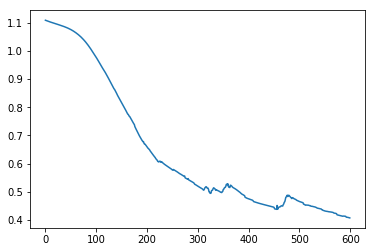

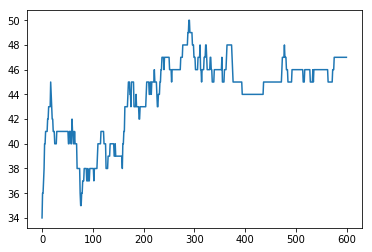

In [113]:
plt.plot(epoch_losses)
plt.show()
plt.plot(epoch_accuracies)
plt.show()

## Save model 

In [114]:
torch.save(model.state_dict(), "passive_force_model.pt")

## Load model and evaluate

In [115]:
model = ComplexRNNModel(input_dim, first_hidden_dim, second_hidden_dim, output_dim)
model.load_state_dict(torch.load("passive_force_model.pt"))
model.eval()
model = model.cuda()

In [116]:
accuracy, predicted = evaluate(model, val_loader, return_predicted=True)

In [117]:
print(accuracy)

tensor(47, device='cuda:0')


In [118]:
predicted = [pred.cpu() for pred in predicted]
Y_val = np.array([y.cpu().numpy() for x, y in val_loader]).reshape(-1)

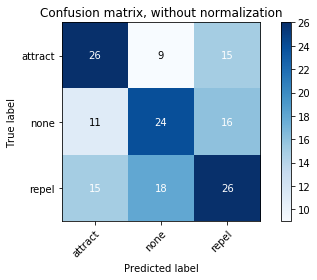

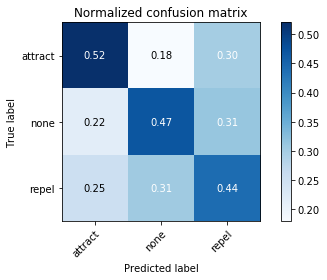

In [119]:
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=False)
plot_confusion_matrix(Y_val, predicted, classes=FORCE_CLASS_COLS, normalize=True)